In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals
from aiplatform.monitoring.atc import antipattern_detection, trace_utils
from IPython.core.display import display, HTML
import argparse, logging, tempfile, json, sys
import pandas
import torchsummary
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 100
display(HTML("<style>.container { width:100% !important; }</style>"))
from pprint import pprint

In [3]:
# From Louis. Trim a long trace so that it eases the ATC processingm
def trim_trace(file_name, start, end):
    assert (0 <= start and start <= 1 and 0 <= end and end <= 1 and start <= end)
    with open(file_name) as trace_file:
        trace = json.load(trace_file)
        min_time = sys.maxsize
        max_time = 0

        for event in trace:
            # print(event['ts'])
            min_time = min(min_time, event['ts'])
            max_time = max(max_time, event['ts'])

        print("time range: {} {}".format(min_time, max_time))
        time_range = max_time - min_time
        offset_start = start * time_range
        offset_end = end * time_range
        # offset from the start to the trimmed end
        max_time = min_time + offset_end
        # move the min time to the offset start
        min_time += offset_start
        print("trimmed time range: {} {}".format(min_time, max_time))
        trimmed_trace = [x for x in trace if x['ts'] > min_time and x['ts'] < max_time]
        with open("trace_trimmed.json", 'w') as out_file:
            json.dump(trimmed_trace, out_file)

In [4]:
# Code copied from //aiplatform/monitoring/atc
def run_ATC():
    # Initiate the logger
    FORMAT = "[%(levelname)s: %(filename)s: %(lineno)4d]: %(message)s"
    logging.basicConfig(level=logging.INFO, format=FORMAT, stream=sys.stdout)
    logger: logging.Logger = logging.getLogger("atc")
    logger.setLevel(logging.INFO)

    # Disable logging if necessary
    logging.disable(sys.maxsize)

    base_trace = "./trace_trimmed.json"

    trace = trace_utils.load_trace_json_file(base_trace)
    base_trace_dir: str = tempfile.mkdtemp(prefix="base-trace_")
    (
        iteration_start_base,
        iteration_end_base,
        all_events_base,
        per_process_events_base,
        per_thread_events_base,
    ) = trace_utils.parse_trace_json(trace, base_trace_dir)
    trace_utils.extract_insights_from_trace(
        base_trace_dir,
        all_events_base,
        per_process_events_base,
        per_thread_events_base,
        iteration_start_base,
        iteration_end_base,
    )

    antipattern_detection.save_all_antipatterns(
        all_events_base,
        per_process_events_base,
        per_thread_events_base,
        output_dir=base_trace_dir,
    )
    logger.info("output directory for base trace: {}".format(base_trace_dir))

    return base_trace_dir

In [5]:
%%capture
trace_file_nb = "./libgpumon_activities_67043.json"
trim_trace(trace_file_nb, 0.91, 0.95)
base_trace_dir = run_ATC()
two_iteration_stats = trace_utils.load_trace_json_file(base_trace_dir + "/two_iteration_trace.json")

In [6]:
# operator_stats = pandas.read_csv(base_trace_dir + "/operator_stats.csv", delimiter='\t')
# op_list = operator_stats["event name"].unique()
# if "## forward ##" not in op_list or "## backward ##" not in op_list:
#     logging.error("Forward and backward tags not set during tracing...")
# forward = operator_stats[operator_stats["event name"] == "## forward ##"]
# backward = operator_stats[operator_stats["event name"] == "## backward ##"]
print(base_trace_dir)

/tmp/base-trace_o0ixeoa9


In [7]:
def list_to_tuple(lst):
    return tuple(list_to_tuple(l) if isinstance(l, list) else l for l in lst) if lst is not None else None

class Event:
    def __init__(self, e, dummy=False):
        if dummy:
            self.event = {
                "name": "dummy",
                "ts": -1,
                "dur": -1,
                "cat": "Runtime",
                "args": {}
            }
        else:
            assert (type(e) == dict)
            self.event = e
        self.parent = None
        self.children = []
        self.has_device_calls = False
    def __str__(self):
        return json.dumps(self.event, sort_keys=True, indent=4, separators=(',', ': '))
#     def __repr__(self):
#         return json.dumps(self.event, sort_keys=True, indent=4, separators=(',', ': '))
    def start_time(self):
        if "ts" not in self.event.keys():
            return None
        return self.event["ts"]
    def duration(self):
        if "dur" not in self.event.keys():
            return None
        return self.event["dur"]
    def category(self):
        if "cat" not in self.event.keys():
            raise TypeError("Unknown event type!")
        return self.event["cat"]
    def name(self):
        if "name" not in self.event.keys():
            raise TypeError("Name lost!")
        return self.event["name"]
    def is_sub_of(self, other):
        assert (self.start_time() is not None and \
                self.duration() is not None and \
                other.start_time() is not None and \
                other.duration() is not None)
        ls = other.start_time()
        le = other.start_time() + other.duration()
        es = self.start_time()
        ee = self.start_time() + self.duration()
        return ls <= es and le >= ee
    def input_shape(self):
        if "args" not in self.event.keys() or "Input dims" not in self.event["args"].keys():
            return (-1,)
        return list_to_tuple(self.event["args"]["Input dims"])
    def output_shape(self):
        if "args" not in self.event.keys() or "Output dims" not in self.event["args"].keys():
            return (-1,)
        return list_to_tuple(self.event["args"]["Output dims"])
    def external_id(self):
        if "args" not in self.event.keys():
            return None

        if ("External id" not in self.event["args"].keys() and \
             "external id" not in self.event["args"].keys()):
            raise TypeError("External id lost!")
        
        if self.category() == "Operator":
            return self.event["args"]["External id"]
        else:
            return self.event["args"]["external id"]
    def correlation_id(self):
        if "args" not in self.event.keys() or self.category() == "Operator":
            return None

        if ("correlation" not in self.event["args"].keys()):
            raise TypeError("Correlation id lost!")
        return self.event["args"]["correlation"]
    def device(self):
        if "args" not in self.event.keys() or \
            ("Device" not in self.event["args"].keys() and \
            "device" not in self.event["args"].keys()):
            return None
        if "Device" in self.event["args"].keys():
            return self.event["args"]["Device"]
        else:
            return self.event["args"]["device"]
    def stream(self):
        if "args" not in self.event.keys() or "stream" not in self.event["args"].keys():
            return None
        return self.event["args"]["stream"]

In [8]:
# Construct a forest to represent the event hierarchy as well as a data structure to hold the relation between ops and device calls
########## cc #########
# {
#     ex_id1 : {
#         caller: - (an op that has one or multiple device calls)
#         callees: {
#             cr_id1: {
#                 launcher: - (cudaKernelLaunch)
#                 executor: - (device kernel)
#             }
#             ...
#         }
#     }
#     ...
# }
def process_event_hierarchy(two, skip_module=False, module_marker="## "):
    
    # Get the "grandest child" event of a given leaf
    # e.g. |------------ A --------------| The leaf event in the frontier currently being accessed
    #         |------------B-----------|
    #            |-----C------| The current "grandest child" of A, since D hasn't been added as A's child yet
    #               |---D---| The event currently being processed
    def get_grandest_child_event(leaf, event, depth=1):
        if not event.is_sub_of(leaf):
            return None
        ret = leaf
        for c in leaf.children:
            grandest = get_grandest_child_event(c, event, depth+1)
            if grandest is not None:
                ret = grandest
                break
        return ret

    roots = [] # All the root events that have no parents
    leaves = [] # The event frontier of the processing
    unaccounted = [] # Unaccounted events (not being used now)
    cc = {} # caller / callee: key = external id, value = { caller event, callee events }
    
    # Sort the event lists and remove all events without a duration
    duration_none = [e for e in two if "dur" not in e.keys()]
    sorted_events = [Event(e) for e in two if e not in duration_none]
    sorted_events = sorted(sorted_events, key=lambda x: (x.start_time(), -x.duration()))
    
    # Remove all leftovers from the last iteration and next iteration
    start_idx = 0
    end_idx = len(sorted_events) - 1
    corrected_start_time = sorted_events[0].start_time()
    corrected_end_time = sorted_events[-1].start_time()
    # Start the analysis from the first module detected, if module is not to be skipped
    for idx, x in enumerate(sorted_events):
        ######## IMPORTANT ########
        # Find the start of an iteration started with "##" without ":". The first module should be "## zero_grad ##" though, 
        # but the current ATC code couldn't start the extraction exactly at there. 
        # Change TORCH_AUTOGRAD_GRAPHROOT in ATC's trace_utils.py does the trick
        if not skip_module and x.name().startswith(module_marker) and ":" not in x.name():
            # The actual start time is the start time of the profiler enter call right before "zero_grad"
            for idy, y in enumerate(reversed(sorted_events[:idx])):
                if y.name() == "profiler::_record_function_enter":
                    start_idx = idx - idy
                    corrected_start_time = y.start_time()
                    break
            break

    # End the analysis at the last event that has a duration. Set the corrected end time later.
    for idx, x in enumerate(reversed(sorted_events)):
        if x.duration() is not None:
            end_idx = idx
            break
    sorted_events = sorted_events[start_idx:(len(sorted_events) - 1 - end_idx)]

    for x in sorted_events:
        # Get start, duration and end time of the current event
        event_start = x.start_time()
        event_duration = x.duration()
        external_id = x.external_id()
        correlation_id = x.correlation_id()

        # Runtime events e.g. cudaLaunchKernel counted as host events
        if x.category() == "Operator" or x.category() == "Runtime":
            if event_start is None or event_duration is None:
                print("Unaccounted event: {}".format(x.event))
                unaccounted.append(x)
                continue
            # Put all OPERATOR events with no device info into unaccounted (0 means None in the trace file)
            # This usually work for events like aten::pin_memory, etc
            if x.device() == 0:
                unaccounted.append(x)
                continue
                
            event_end = event_start + event_duration
            corrected_end_time = max(event_end, corrected_end_time)

            # Find parent of the current event from the frontier
            parent_found = False
            to_add_root = None
            to_add_leaf = None
            for l in leaves:
                leaf_start = l.start_time()
                leaf_end = leaf_start + l.duration()

                # The current event is sub to leaf
                if event_end <= leaf_end:
                    # Add this event to the GRANDEST CHILD of the leaf that can sub it
                    grandest = get_grandest_child_event(l, x)
                    x.parent = grandest
                    grandest.children.append(x)
                    to_add_leaf = x
                    parent_found = True
                    break
                # The current event has no overlap with leaf
                elif event_start >= leaf_end:
                    continue
                # Crossover shouldn't happen
                else:
                    pprint(str(x))
                    raise ValueError("\tCrossover happens!")

            # New root and leaf
            if not parent_found:
                to_add_root = x
                to_add_leaf = x
            if to_add_root:
                roots.append(to_add_root)
            if to_add_leaf:
                leaves.append(to_add_leaf)
            
            # Add op to caller or unaccounted
            if x.category() == "Operator":
                if external_id != 0:
                    if external_id not in cc.keys():
                        cc[external_id] = {}  
                    cc[external_id]["caller"] = x
                    cc[external_id]["callees"] = {}
            else: # Runtime
                if external_id != 0 and correlation_id != 0: # Not consider some events without ex_id and cr_id, e.g. cudaEventCreateWithFlags
                    if external_id not in cc.keys():
                        cc[external_id] = {}
                    if "caller" not in cc[external_id].keys():
                        cc[external_id]["caller"] = None
                    if "callees" not in cc[external_id].keys():
                        cc[external_id]["callees"] = {}
                    if correlation_id not in cc[external_id]["callees"].keys():
                        cc[external_id]["callees"][correlation_id] = {}
                        cc[external_id]["callees"][correlation_id]["launcher"] = None
                        cc[external_id]["callees"][correlation_id]["executor"] = None
                    cc[external_id]["callees"][correlation_id]["launcher"] = x
        else:
            # Skip modules if needed
            if (skip_module and x.name().startswith(module_marker)):
                continue
            else: # "cat" = "Memcpy" or "Kernel", i.e. callee
                if external_id != 0 and correlation_id != 0: # Doesn't consider some events without ex_id and cr_id, e.g. cudaEventCreateWithFlags
                    if external_id not in cc.keys():
                        cc[external_id] = {}
                    if "caller" not in cc[external_id].keys():
                        cc[external_id]["caller"] = None
                    if "callees" not in cc[external_id].keys():
                        cc[external_id]["callees"] = {}
                    if correlation_id not in cc[external_id]["callees"].keys():
                        cc[external_id]["callees"][correlation_id] = {}
                        cc[external_id]["callees"][correlation_id]["launcher"] = None
                        cc[external_id]["callees"][correlation_id]["executor"] = None
                    cc[external_id]["callees"][correlation_id]["executor"] = x
            
    # Set the corrected_end_time to be the last event's end time
    for x in reversed(roots):
        if x.duration() is not None:
            corrected_end_time = x.start_time() + x.duration()
            break
            
    # Update 'has_device_calls' for all events in the tree
    def update_has_device_calls(roots):
        for r in roots:
            ex_id = r.external_id()
            if len(r.children) == 0:
                if ex_id in cc.keys() and len(cc[ex_id]["callees"].keys()) != 0:
                    for k, v in cc[ex_id]["callees"].items():
                        if v["executor"] is not None:
                            r.has_device_calls = True
            else:
                update_has_device_calls(r.children)
                for c in r.children:
                    if c.has_device_calls:
                        r.has_device_calls = True
    update_has_device_calls(roots)

    return roots, cc, corrected_start_time, corrected_end_time

def get_device_runtime_and_start_delay(cc, corrected_start_time):
    device_runtime = 0
    device_start_delay = 1000000000000000

    for ex_id, v in cc.items():
        for cr_id, vv in v["callees"].items():
            if vv["executor"] is not None:
                device_start_delay = min(device_start_delay, vv["executor"].start_time() - corrected_start_time)

                if "batched_embedding_forward_kernel" in vv["executor"].name():
                    if device_runtime == 0:
                        device_runtime = vv["executor"].start_time()
                    else:
                        device_runtime = vv["executor"].start_time() - device_runtime
                        device_runtime *= 2
                        if device_runtime < 0:
                            device_runtime = 0 - device_runtime
    
    return device_runtime, device_start_delay

def get_host_runtime_breakdown(events, cc, total_time):
    runtime_breakdown = {}

    def construct_rb(events, rb):
        for e in events:
            name = e.name()
            shape = (e.input_shape(), e.output_shape())
            ex_id = e.external_id()
            if name not in rb.keys():
                rb[name] = {}
                rb[name]["subs"] = {} # All the children
                rb[name]["runtime"] = 0.0 # Event runtime seen on the host
                rb[name]["stats"] = {}
            rb[name]["runtime"] += e.duration()
            
            if shape not in rb[name]["stats"].keys():
                rb[name]["stats"][shape] = {}
                rb[name]["stats"][shape]["count"] = 0
            rb[name]["stats"][shape]["count"] += 1

            # DFS for children
            construct_rb(e.children, rb[name]["subs"])

    construct_rb(events, runtime_breakdown)
    runtime_breakdown = {
        "runtime": total_time,
        "subs": runtime_breakdown
    }

    return runtime_breakdown

def print_host_results(rb, depth_limit=sys.maxsize, truncate_count=100, depth=0):
    t = rb["runtime"]
    if depth == 0:
        print(f"Two iteration runtime: {t:>20} (in us, same below)")

    module_perc_sum = 0
    dominated_perc_sum = 0
    dominated_count = 0
    space_padding = " " * (depth + 1) * 5
    for k, v in sorted(rb["subs"].items(), key=lambda x: x[1]["runtime"], reverse=True):
        vt = str(v["runtime"])
        perc = v["runtime"] / t
        module_perc_sum += perc
        # Truncate results for brevity
        if dominated_count < truncate_count:
            dominated_perc_sum += perc
            count = 0
            for kk, vv in v["stats"].items():
                count += vv["count"]
            print(f"{space_padding}{(k+':'):<40} {('(' + vt):>{(depth+2) * 5}}, {(perc * 100):.2f}%, {count})")

            # DFS and print
            if depth < depth_limit and len(v["subs"].keys()) != 0:
                print_host_results(v, depth_limit, truncate_count, depth=depth+1)
            dominated_count += 1

    # If there's still remaining time, print it under "Others"
    if abs(module_perc_sum - dominated_perc_sum) > 1e-4:
        other_time = "{:.1f}".format((module_perc_sum - dominated_perc_sum) * t)
        print(f"{space_padding}{'Others:':<40} {('(' + other_time):>{(depth+2) * 5}}, {((module_perc_sum - dominated_perc_sum) * 100):.2f}%)")

    # Unaccounted time
    unaccounted_time = "{:.1f}".format((1 - module_perc_sum) * t)
    print(f"{space_padding}{'Unaccounted:':<40} {('(' + unaccounted_time):>{(depth+2) * 5}}, {((1 - module_perc_sum) * 100):.2f}%)")
    
# Get root operators, not including modules
def get_operators(roots, ops):
    for r in roots:
        # Is an operator, and
        # Not a module or submodule, and
        # (Parent is a module, or, is simply a root operator)
        if r.category() == "Operator" and\
            (not r.name().startswith("## ")) and ((\
            r.parent is not None and\
            r.parent.name().startswith("## ")\
        ) or (\
            r.parent is None\
        )) :
            ops.append(r)
        else:
            get_operators(r.children, ops)
            
# Shorten name for some heavily templated kernels
def shorten_kernel_name(name):
    if '<' in name:
        name = name.split('<')[0]
    if '::' in name:
        name = name.split('::')[-1]
    return name

#######################
# {
#    ex_id1: {
#         stream1 : {
#             (executor_name1, shape1): {
#                 count: - (cudaKernelLaunch)
#                 runtime: - (device kernel)
#             }
#             ...
#         }
#         ...
#    }
#    ...
# }
def get_device_runtime(roots, cc, depth=0):
    result = {}
    for r in roots:
        if not r.has_device_calls:
            continue
        name = r.name()
        external_id = r.external_id()
        r_shape = r.input_shape()
        tmp_result = {}
        if len(r.children) == 0: # No children: either cudaLaunchKernel or host ops that have no device calls
            tmp_stats = {}
            correlation_id = r.correlation_id()
            v = cc[external_id]["callees"][correlation_id]
            lc, ex = v["launcher"], v["executor"]
            if ex is None:
                # Dummy: no executor runtime
                pass
            elif lc is not None:
                lc_dur, ex_dur = lc.duration(), ex.duration()

                ##############################################################
                # TODO: Maybe there's a better way to model the device time, e.g. involving overheads of some operators
                device_total = ex_dur
                ##############################################################

                # Important stats: type (name): { shapes: count & time }
                # Shorten executor name too long
                executor_name = shorten_kernel_name(ex.name())
                cl = cc[external_id]["caller"]
                if cl is None:
                    shape = (-1,)
                else:
                    shape = cl.input_shape()
                key = (executor_name, shape)
                stream = ex.stream()
                assert (stream is not None)
                if stream not in tmp_stats.keys():
                    tmp_stats[stream] = {}
                if key not in tmp_stats[stream].keys():
                    tmp_stats[stream][key] = {}
                    tmp_stats[stream][key]["count"] = 0
                    tmp_stats[stream][key]["runtime"] = 0.0
                tmp_stats[stream][key]["count"] += 1
                tmp_stats[stream][key]["runtime"] += device_total
            tmp_result = {-1: tmp_stats}
        else: # If has children, go to the next level
            tmp_result = get_device_runtime(r.children, cc, depth=depth+1)

        if external_id not in result.keys():
            result[external_id] = {}
        dict_pointer = result[external_id]

        # Merge results from lower levels
        for _, tmp_stats in tmp_result.items():
            for stream, v in tmp_stats.items():
                if stream not in dict_pointer.keys():
                    dict_pointer[stream] = {}
                for key, vv in v.items():
                    if key not in dict_pointer[stream].keys():
                        dict_pointer[stream][key] = {}
                        dict_pointer[stream][key]["count"] = 0
                        dict_pointer[stream][key]["runtime"] = 0.0
                    dict_pointer[stream][key]["count"] += vv["count"]
                    dict_pointer[stream][key]["runtime"] += vv["runtime"]

    # Remove all entries without correlation ids
    if depth == 0:
        to_be_deleted = []
        for ex_id, v in result.items():
            delete = True
            for stream, vv in v.items():
                if len(list(vv.keys())) != 0:
                    delete = False
            if delete:
                to_be_deleted.append(ex_id)
        for ex_id in to_be_deleted:
            del result[ex_id]
    return result

def print_all_device_results(roots, odr, total_time, depth=0):
    space_padding = " " * depth * 4
    tmp_space_padding = " " * (depth + 1) * 4
    for r in roots:
        ex_id = r.external_id()
        if r.has_device_calls:
            print(f"{space_padding}{r.name()}")
            if ex_id in odr.keys():
                result = odr[ex_id]
                for key, v in result.items():
                    kernel_name = key[0]
                    shape = key[1]
                    kernel_count = v["count"]
                    kernel_time = v["runtime"]
                    print(f"{tmp_space_padding}{(kernel_name+':'):<44} {('( ' + str(shape)):>{(depth+2) * 4}}, {kernel_count}, {kernel_time} )")
            else:
                print_all_device_results(r.children, odr, -1, depth=depth+1)

########### device runtime breakdown ############
# {
#    stream1: {
#         runtime: -
#         (module_name1, ()): {
#             runtime: -
#             count: -
#             occ: [
#                 {
#                     runtime: -
#                     (op_name1, shape1): {
#                     }
#                     ...
#                 }
#                 ...
#             ]
#         }
#         ...
#    }
#    ...
# }
def device_runtime_breakdown(ops, odr, total_time, depth=0):
    result = {}
    for r in ops:
        ex_id = r.external_id()
        if r.has_device_calls:
            key = (r.name(), r.input_shape())
            if ex_id in odr.keys(): # The current event is a caller (STILL AN OPERATOR!)
                tmp_stats = {}
                for stream, v in odr[ex_id].items():
                    if stream not in tmp_stats.keys():
                        tmp_stats[stream] = {}
                        tmp_stats[stream]["runtime"] = 0.0
                    for tmp_key, vv in v.items():
                        kernel_count = vv["count"]
                        kernel_time = vv["runtime"]
                        if tmp_key not in tmp_stats[stream].keys():
                            tmp_stats[stream][tmp_key] = {}
                            tmp_stats[stream][tmp_key]["count"] = 0
                            tmp_stats[stream][tmp_key]["runtime"] = 0.0
                        tmp_stats[stream][tmp_key]["count"] += kernel_count
                        tmp_stats[stream][tmp_key]["runtime"] += kernel_time
                        tmp_stats[stream]["runtime"] += kernel_time
            else:
                tmp_stats = device_runtime_breakdown(r.children, odr, -1, depth=depth+1)

            for stream, v in tmp_stats.items():
                if stream not in result.keys():
                    result[stream] = {}
                    result[stream]["runtime"] = 0.0
                if key not in result[stream].keys():
                    result[stream][key] = {}
                    result[stream][key]["count"] = 0
                    result[stream][key]["runtime"] = 0.0
                    result[stream][key]["occ"] = []
                result[stream]["runtime"] += v["runtime"]
                result[stream][key]["count"] += 1
                result[stream][key]["runtime"] += v["runtime"]
                result[stream][key]["occ"].append(v)
    return result
                
def print_major_device_results(drb, flatten, parent_name="total", truncate_count=100, depth=0):
    t = drb["runtime"]
    t_perc = t / device_runtime * 100.0
    if t == 0.0:
        return
    idle = device_runtime - t
    idle_perc = idle / device_runtime * 100.0
    
    if depth == 0:
        print(f"    Total device time: {(device_runtime)} (in us, same below)")
        print(f"    Device active time: {t} ({t_perc:.2f}%)")
        print(f"    Device idle time: {idle} ({idle_perc:.2f}%)")
        
    module_perc_sum = 0
    dominated_perc_sum = 0
    dominated_count = 0
    space_padding = " " * ((depth + 1) * 2 + 4)
    
    if parent_name not in flatten.keys():
        flatten[parent_name] = {}
        flatten[parent_name]["runtime"] = 0.0
        flatten[parent_name]["subs"] = {}
    flatten[parent_name]["runtime"] += t
    
    for key, v in sorted(drb.items(), key=lambda x: x[1]["runtime"] if (isinstance(x[1], dict) and "runtime" in x[1].keys()) else -1, reverse=True):
        if key == "runtime":
            continue
        vt = str(v["runtime"])
        perc = v["runtime"] / t
        module_perc_sum += perc
        count = v["count"]
        # Truncate results for brevity
        if dominated_count < truncate_count:
            dominated_perc_sum += perc
            name = key[0]
            shape = str(key[1])
            if shape == '()' or shape == "((),)":
                print(f"{space_padding}{(name+':'):<52} {('(' + vt):>{(depth+2) * 3}}, {(perc * 100):.2f}%, {count})")
            else:
                print(f"{space_padding}{(name+':'):<52} {('(' + vt):>{(depth+2) * 3}}, {(perc * 100):.2f}%, {count}) {(shape):>60}")
                
            # DFS and print
            if "occ" in v.keys(): # Only ops and modules have 'occ', saving all occurences of this op or module with roughly the same runtime
                print_major_device_results(v["occ"][0], flatten, parent_name=key, truncate_count=truncate_count, depth=depth+1)
                
            dominated_count += 1

            if parent_name not in flatten:
                flatten[parent_name] = {}
                flatten[parent]
                flatten[parent_name][key] = {}
            if key not in flatten[parent_name]["subs"].keys():
                flatten[parent_name]["subs"][key] = 0.0
            flatten[parent_name]["subs"][key] += v["runtime"]

    # If there's still remaining time, print it under "Others"
    if abs(module_perc_sum - dominated_perc_sum) > 1e-4:
        other_time = "{:.1f}".format((module_perc_sum - dominated_perc_sum) * t)
        print(f"{space_padding}{'Others:':<52} {('(' + other_time):>{(depth+2) * 5}}, {((module_perc_sum - dominated_perc_sum) * 100):.2f}%)")
        if "others" not in flatten[parent_name]["subs"].keys():
            flatten[parent_name]["subs"]["others"] = 0.0
        flatten[parent_name]["subs"]["others"] += float(other_time)
        
    # Unaccounted time
    if abs(1 - module_perc_sum) > 1e-4:
        unaccounted_time = "{:.1f}".format((1 - module_perc_sum) * t)
        print(f"{space_padding}{'Unaccounted:':<52} {('(' + unaccounted_time):>{(depth+2) * 5}}, {((1 - module_perc_sum) * 100):.2f}%)")
        if "unaccounted" not in flatten[parent_name]["subs"].keys():
            flatten[parent_name]["subs"]["unaccounted"] = 0.0
        flatten[parent_name]["subs"]["unaccounted"] += float(unaccounted_time)
        
# def get_common_shapes(op_stats=None, roots=None):
#     assert (not (op_stats is None and roots is None))
#     shapes = {}
    
#     def get_shapes_from_df(op_stats, shapes):
#         # Implement later
#         pass
    
#     def get_shapes(events, shapes):
#         for e in events:
#             name = e.name()
#             if name not in shapes.keys():
#                 shapes[name] = set()
                
#             shape = (e.input_shape(), e.output_shape())
#             if shape != ((-1,), (-1,)):
#                 shapes[name].add(shape)
            
#             # DFS for children
#             get_shapes(e.children, shapes)

#     if op_stats is not None:
#         get_shapes_from_df(op_stats, shapes)
#     else:
#         get_shapes(roots, shapes)
#     return shapes

In [9]:
roots, cc, corrected_start_time, corrected_end_time = process_event_hierarchy(two_iteration_stats, skip_module=False)
# print(len(two_iteration_stats), len(roots), len(cc))
print("Start time: ", corrected_start_time, ", end time: ", corrected_end_time)
# print(iteration_start_base, iteration_end_base)
host_runtime = corrected_end_time - corrected_start_time
print("Host runtime: ", host_runtime)
device_runtime, device_start_delay = get_device_runtime_and_start_delay(cc, corrected_start_time)
print("Device runtime: ", device_runtime)
print("Device start delay: ", device_start_delay)
ops = []
get_operators(roots, ops)
QPS = 1000000 / host_runtime * 2 * 512
print(f"QPS: {QPS:.2f}")

Start time:  48559 , end time:  71896
Host runtime:  23337
Device runtime:  23806
Device start delay:  1067
QPS: 43878.82


### Host runtime breakdown

In [10]:
depth_limit = 2
truncate_count = 3
host_runtime_breakdown = get_host_runtime_breakdown(roots, cc, host_runtime)
print_host_results(host_runtime_breakdown, depth_limit, truncate_count)

Two iteration runtime:                23337 (in us, same below)
     ## backward ##:                             (9892.0, 42.39%, 2)
          AddmmBackward:                                   (2712.0, 27.42%, 20)
               aten::mm:                                             (1742.0, 64.23%, 38)
               aten::t:                                               (720.0, 26.55%, 58)
               Unaccounted:                                           (250.0, 9.22%)
          torch::autograd::AccumulateGrad:                 (1952.0, 19.73%, 42)
               aten::copy_:                                          (1114.0, 57.07%, 40)
               aten::empty_strided:                                   (507.0, 25.97%, 40)
               aten::add_:                                             (60.0, 3.07%, 2)
               Unaccounted:                                           (271.0, 13.88%)
          aten::sum:                                        (856.0, 8.65%, 22)
         

In [11]:
op_device_runtime = get_device_runtime(ops, cc) # dict: op ex_id -> all its device calls and stats
# pprint(op_device_runtime)
# print_all_device_results(roots, op_device_runtime, device_runtime, depth=0)
# shapes = get_common_shapes(None, roots)
# pprint(shapes)

### Ops in the forward pass

In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)
op_names = []
op_input_shapes = []
op_duration = []
for op in ops:
    if op.parent is not None and op.parent.name().startswith("## forward"):
        op_names.append(op.name())
        op_input_shapes.append(op.input_shape())
        op_duration.append(op.duration())
forward_ops = pd.DataFrame(list(zip(op_names, op_input_shapes, op_duration)), columns=["names", "shapes", "duration (us)"])
# forward_ops

### Device runtime breakdown

In [57]:
dt_breakdown = device_runtime_breakdown(roots, op_device_runtime, device_runtime, depth=0)
# pprint(dt_breakdown)
truncate_count = 10
flatten = {}
for stream, v in dt_breakdown.items():
    print("Stream: {}".format(stream))
    flatten[stream] = {}
    print_major_device_results(dt_breakdown[stream], flatten[stream], truncate_count=truncate_count)
# pprint(flatten)

Stream: 7
    Total device time: 23806 (in us, same below)
    Device active time: 11707.0 (49.18%)
    Device idle time: 12099.0 (50.82%)
      ## backward ##:                                      (8757.0, 74.80%, 2)
        LookupFunctionBackward:                                (2904.0, 66.32%, 1)                                            ((512, 197, 64),)
          void batched_embedding_backward_sgd_kernel_1:             (2904.0, 100.00%, 1)                                            ((512, 197, 64),)
        AddmmBackward:                                          (226.0, 5.16%, 1)                                                ((512, 287),)
          volta_sgemm_128x64_nn:                                     (127.0, 56.19%, 1)                                    ((512, 287), (287, 3482))
          volta_sgemm_128x64_nt:                                      (95.0, 42.04%, 1)                                    ((287, 512), (512, 3482))
          Memset (Device):                     

                        Compute Stream


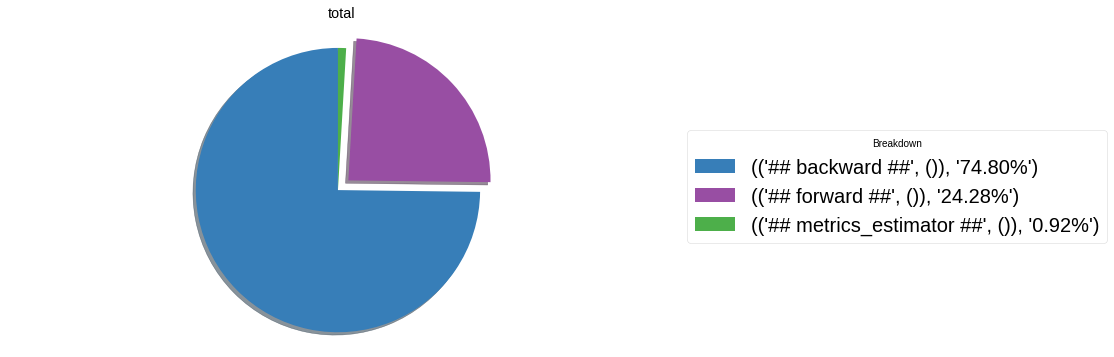

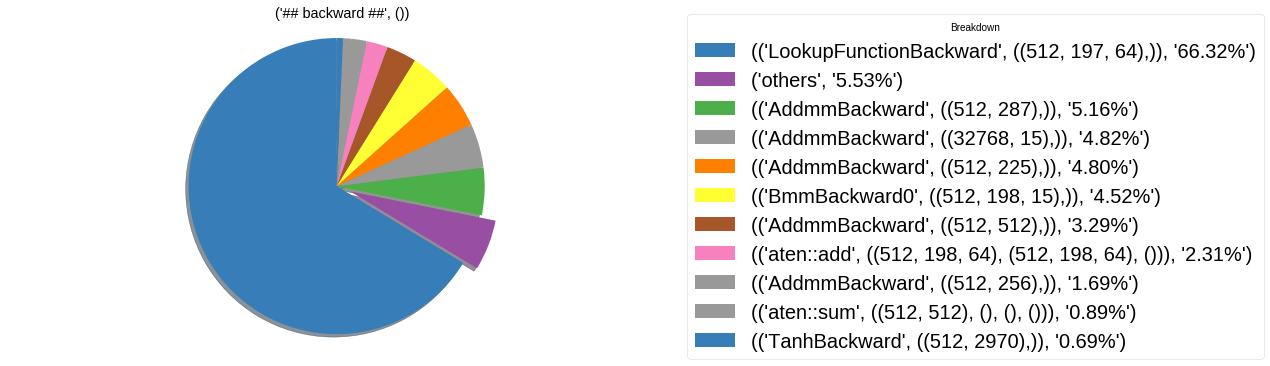

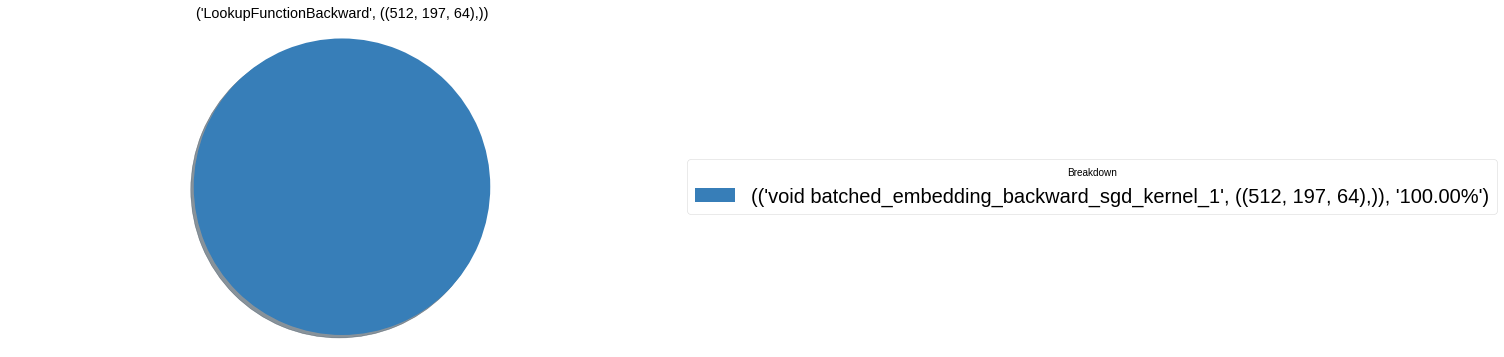

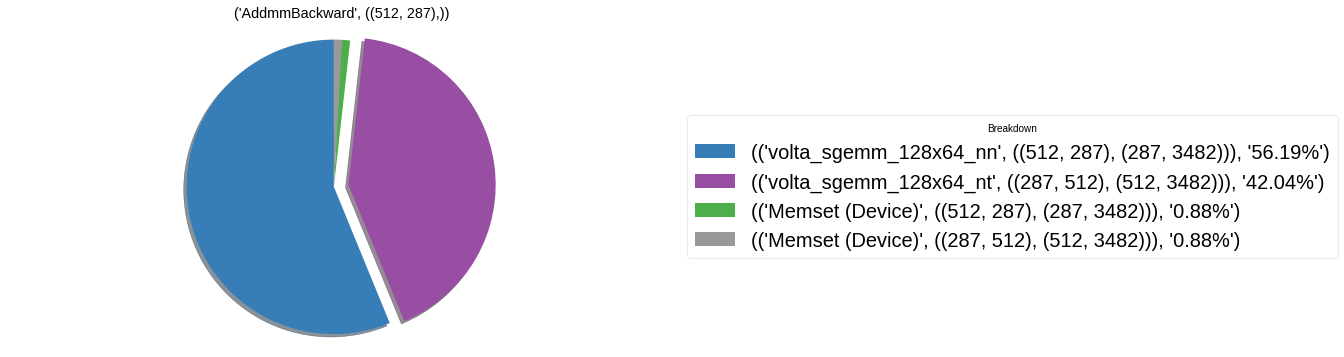

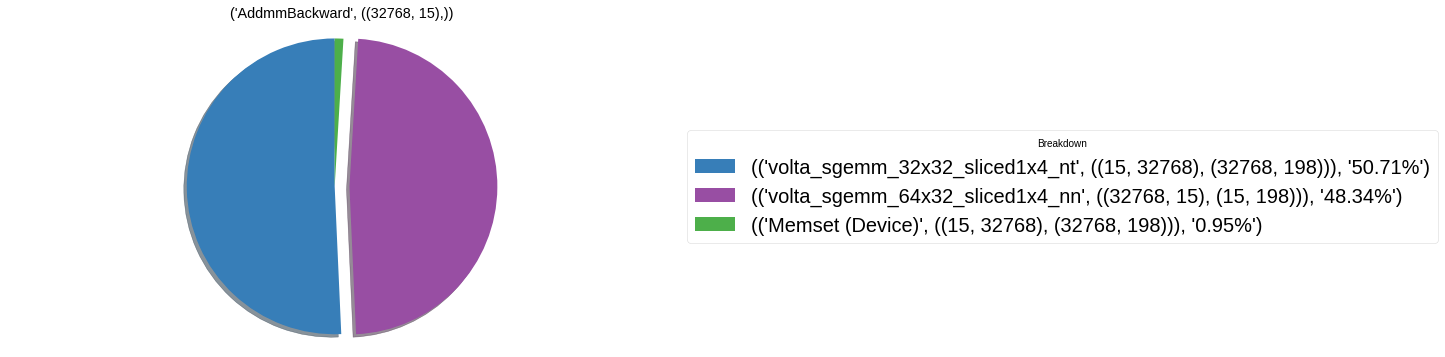

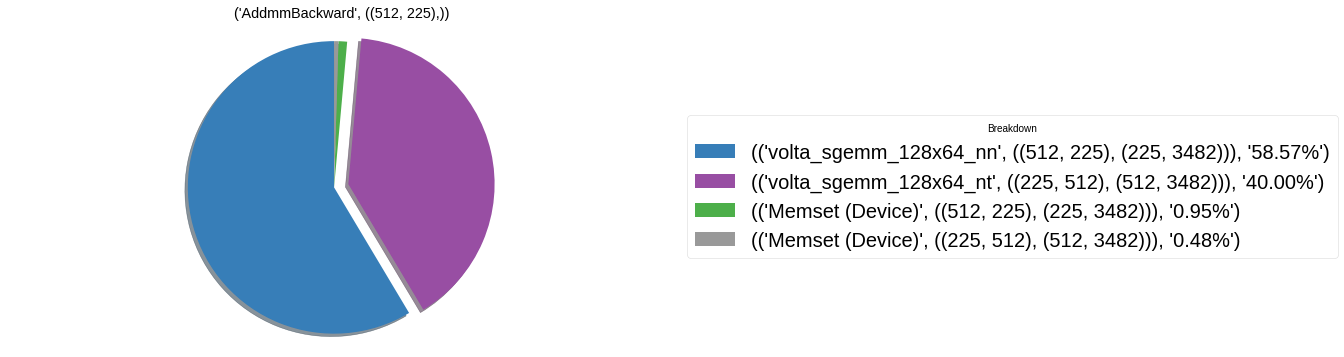

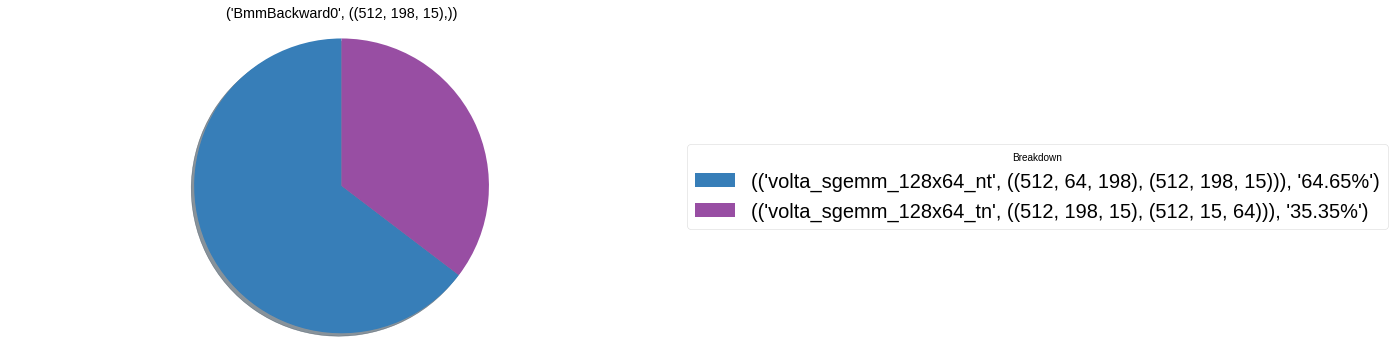

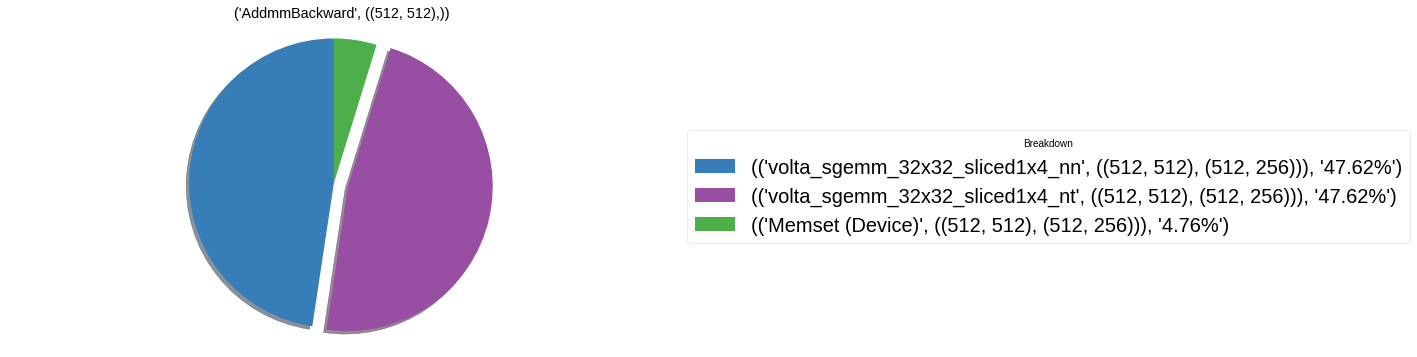

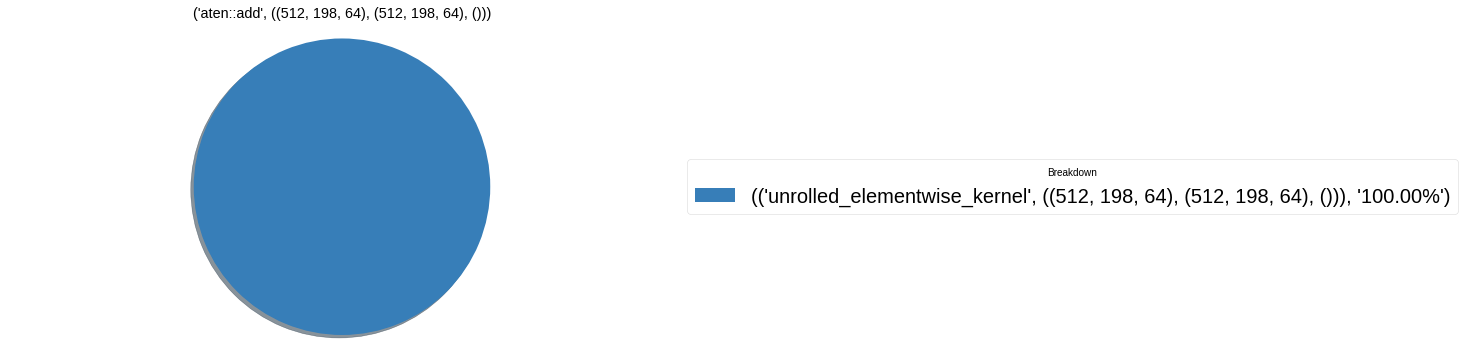

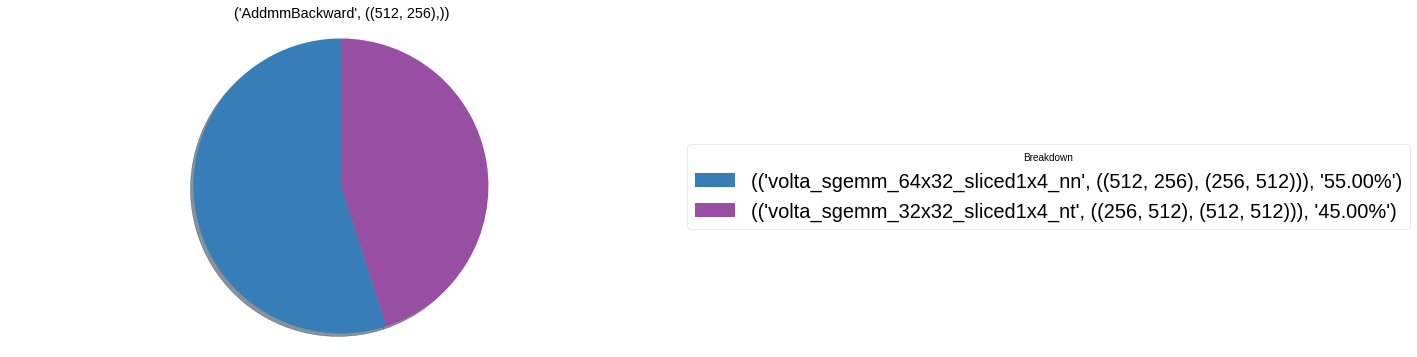

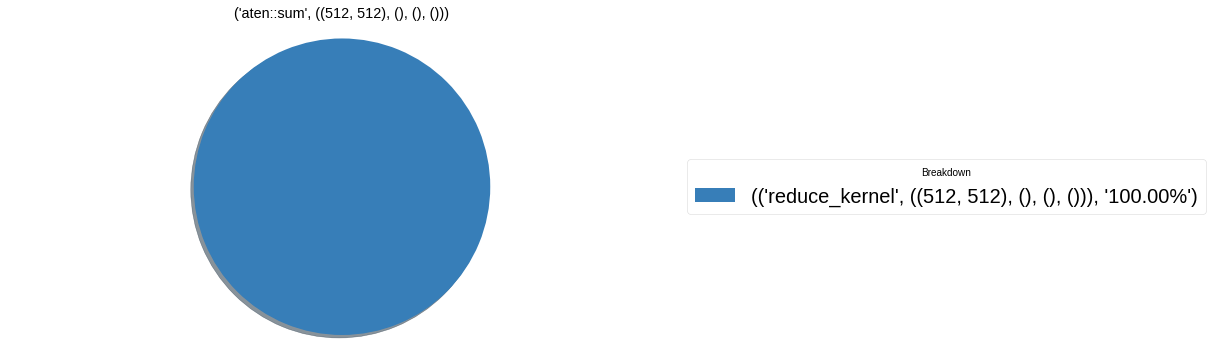

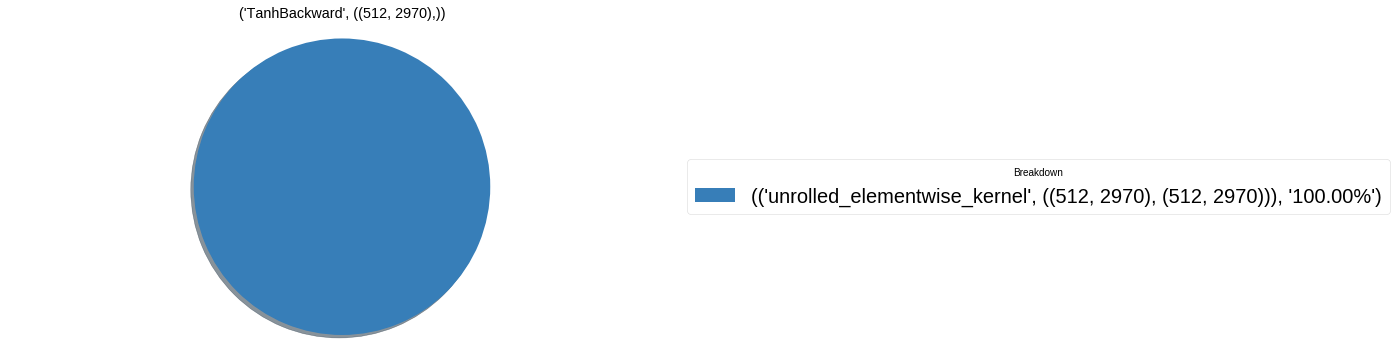

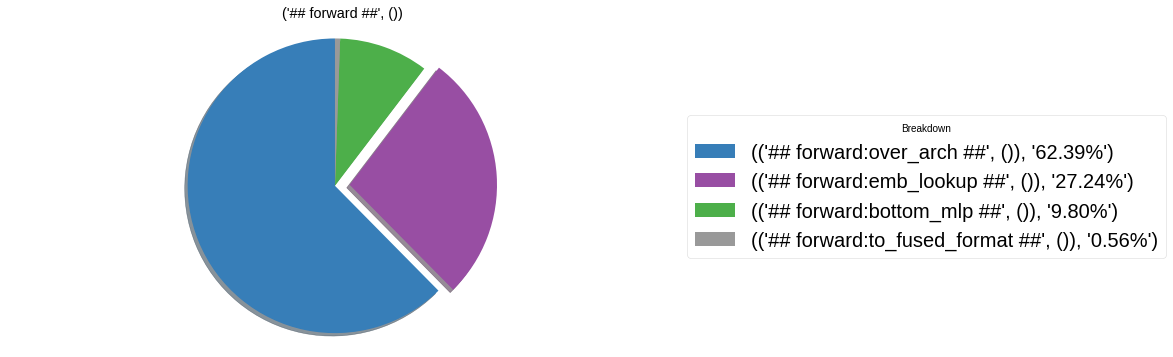

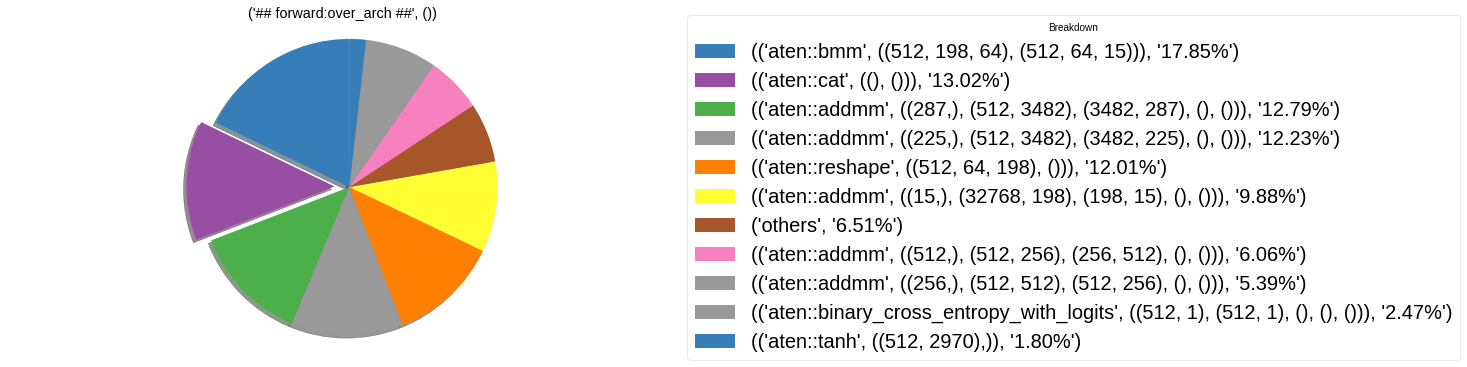

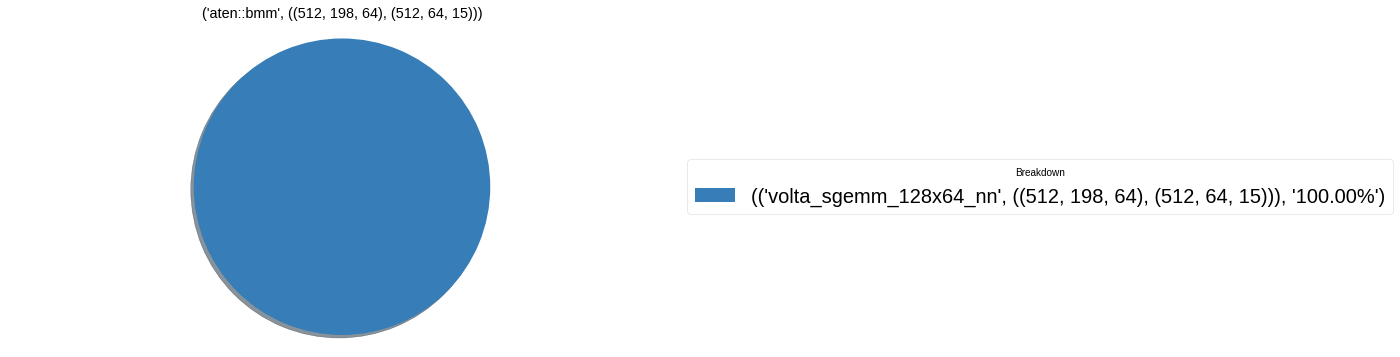

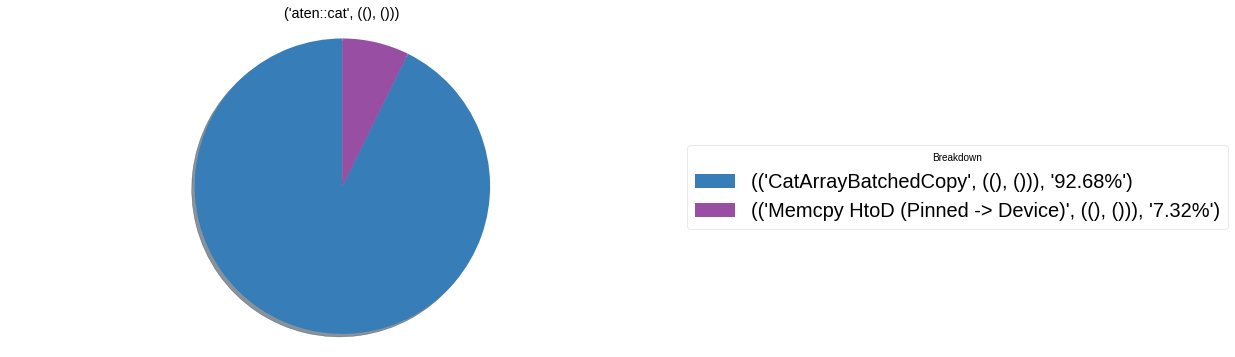

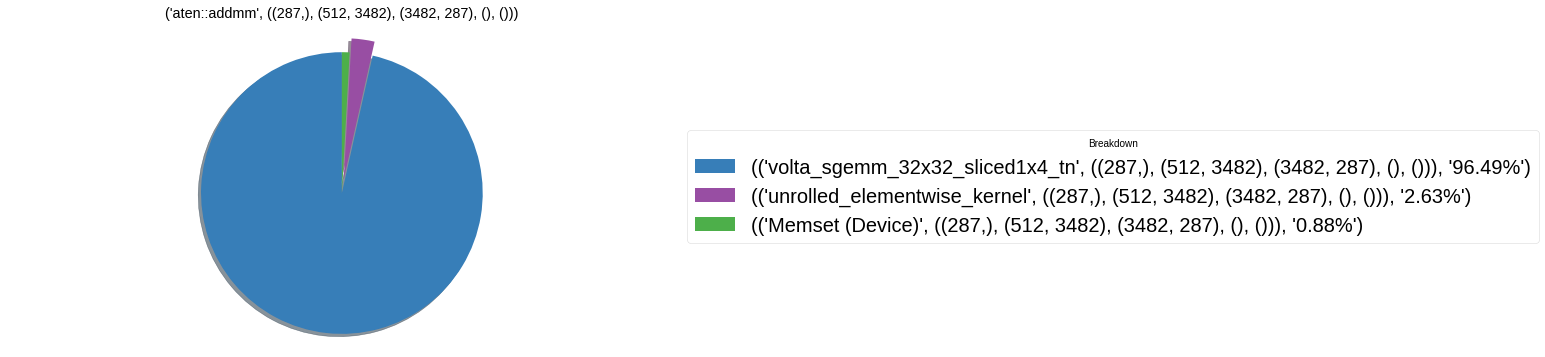

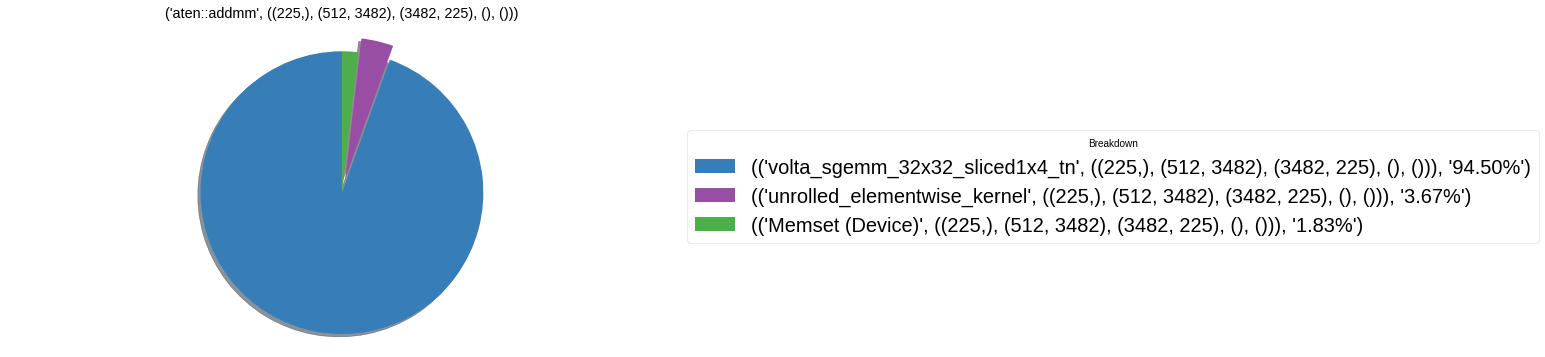

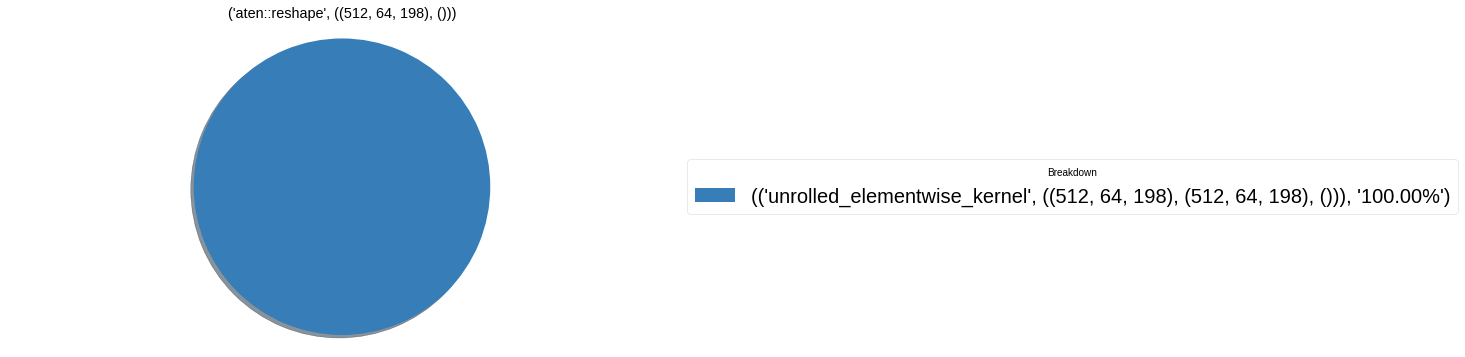

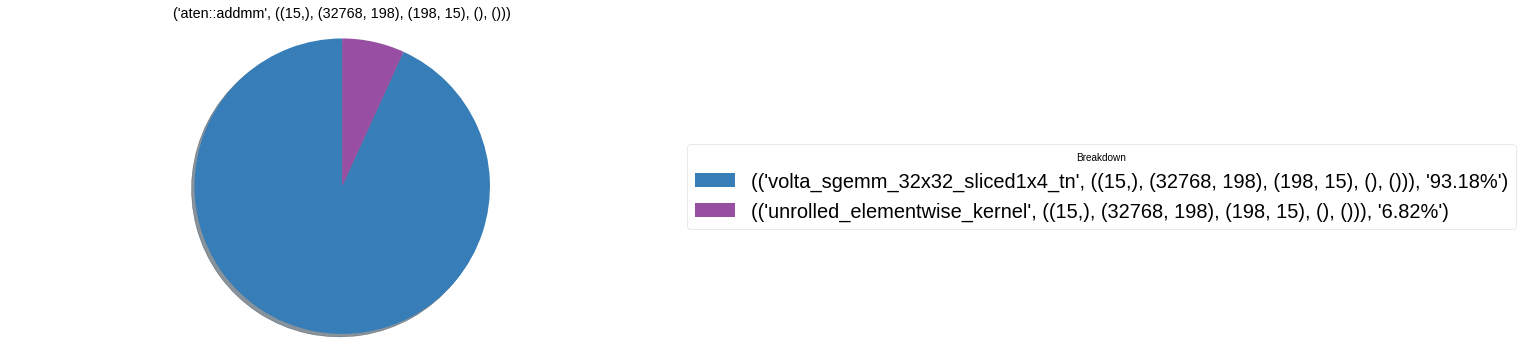

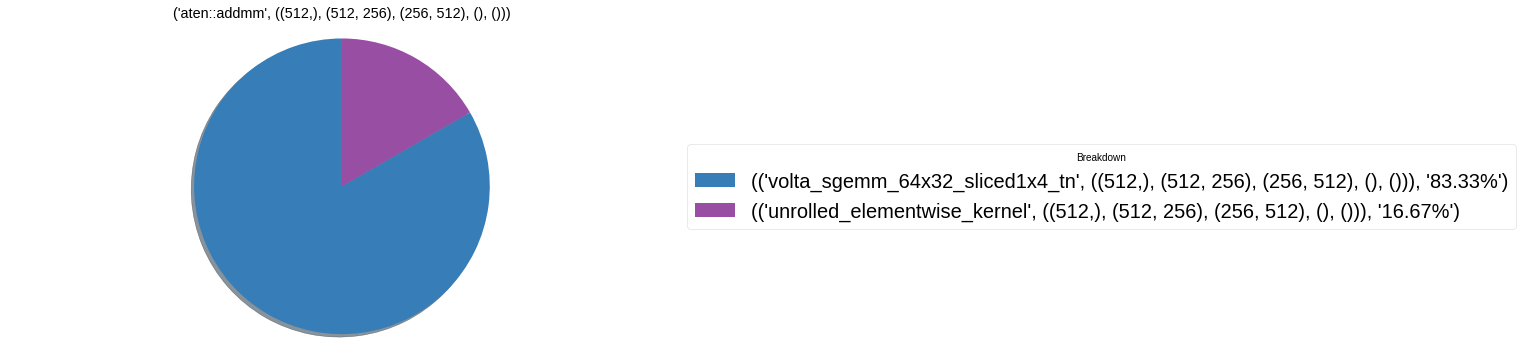

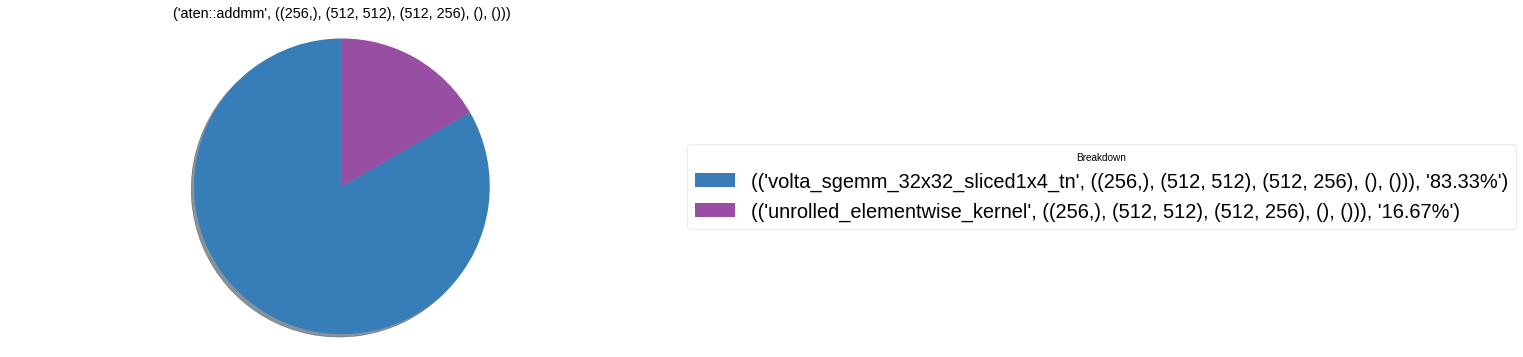

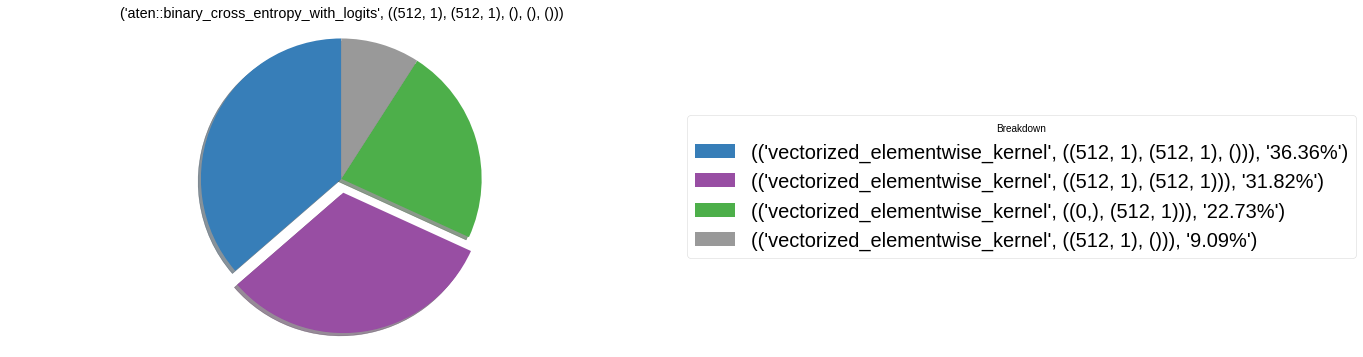

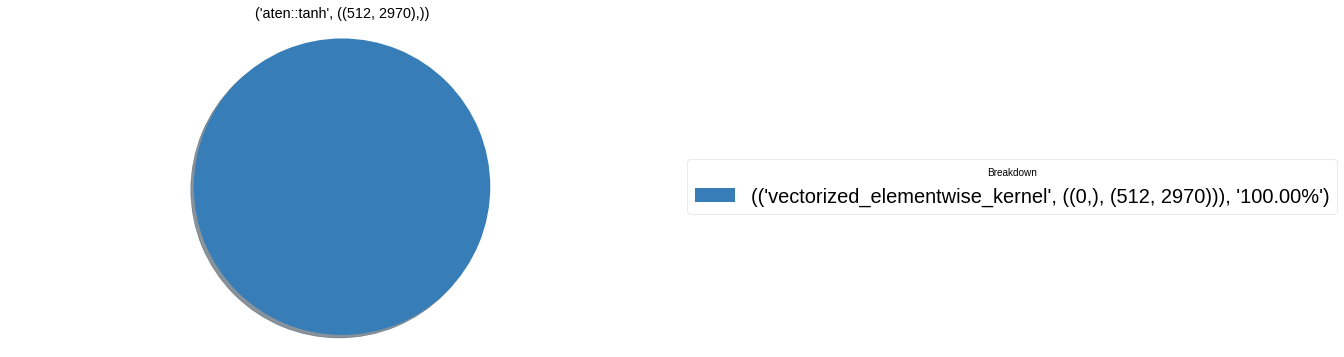

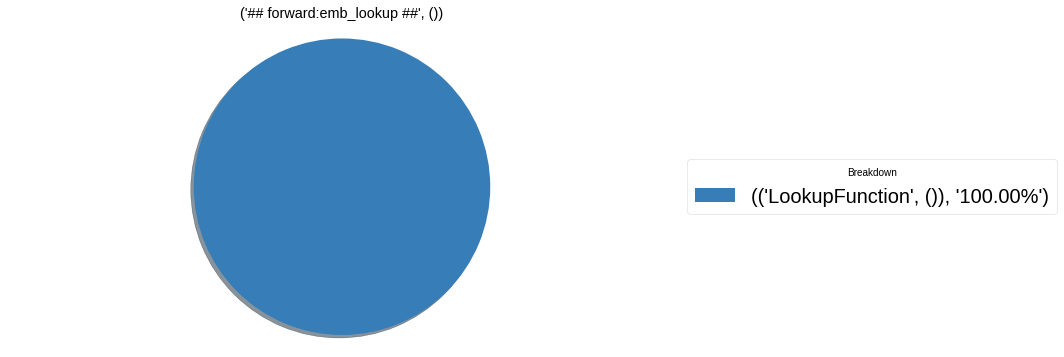

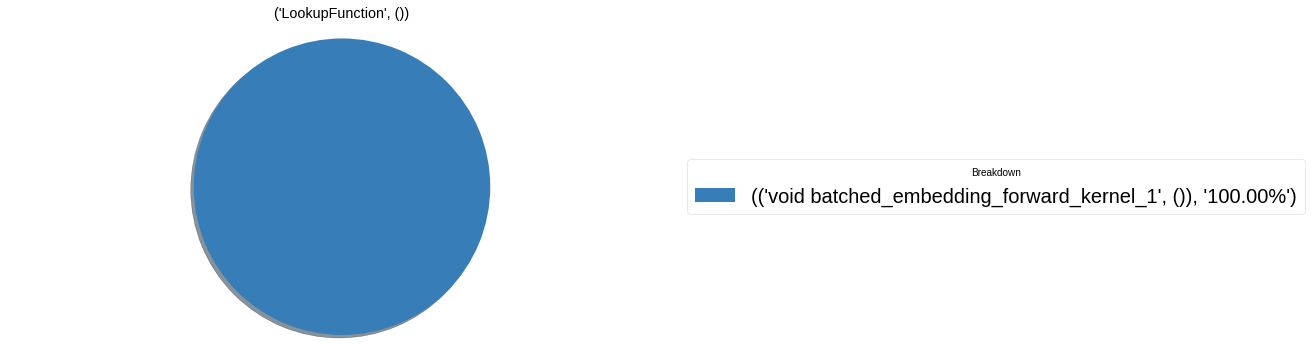

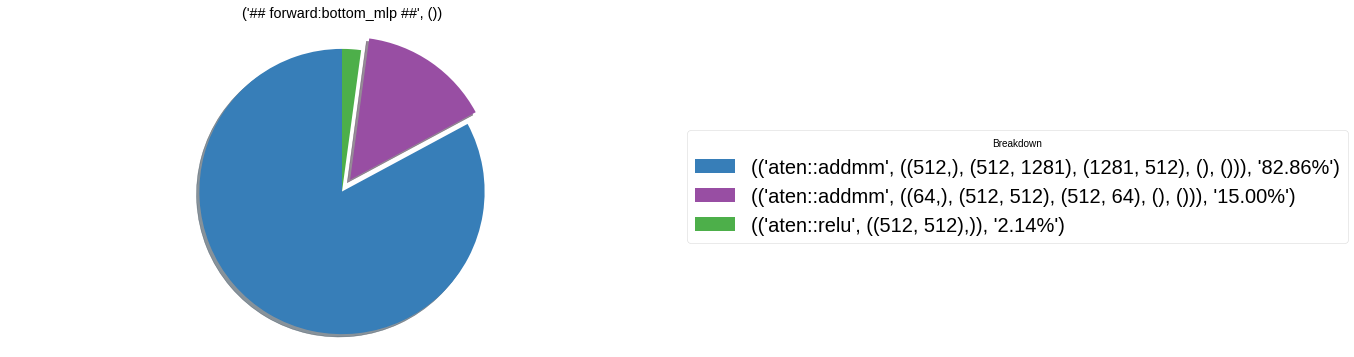

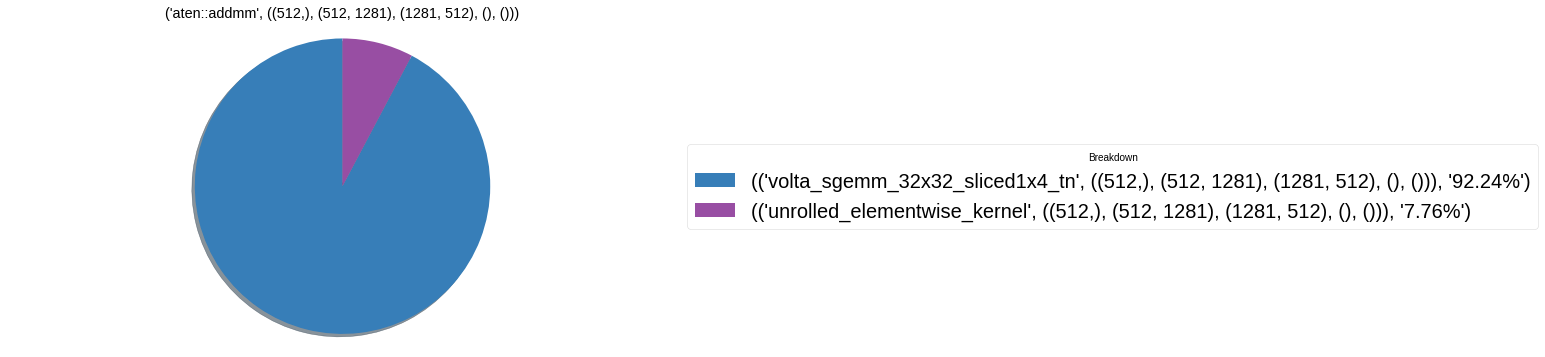

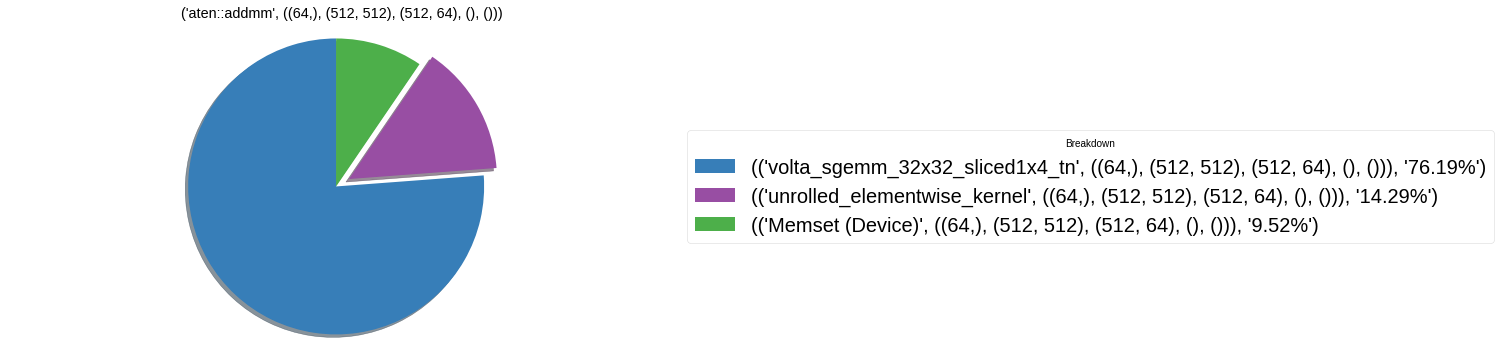

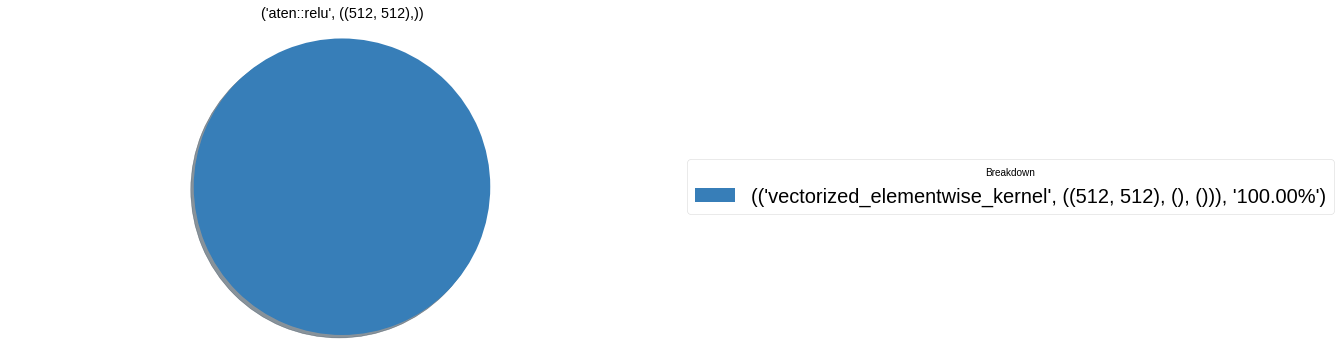

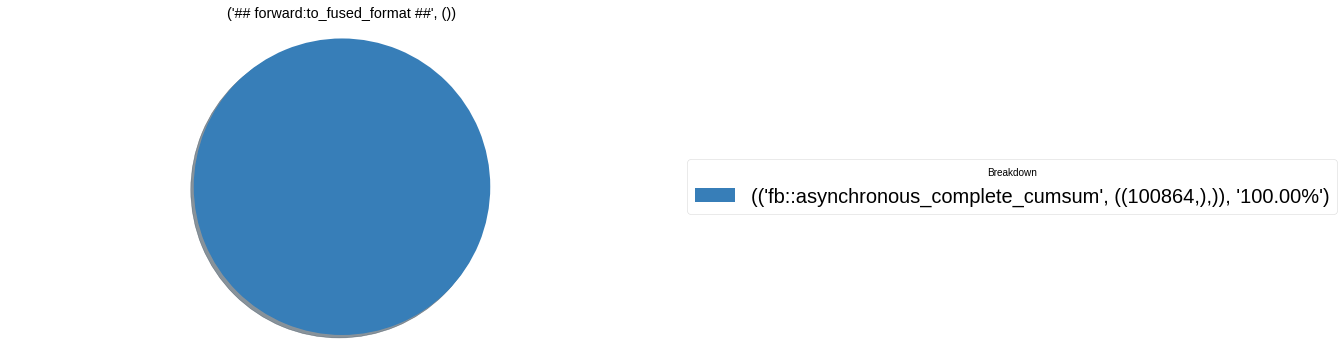

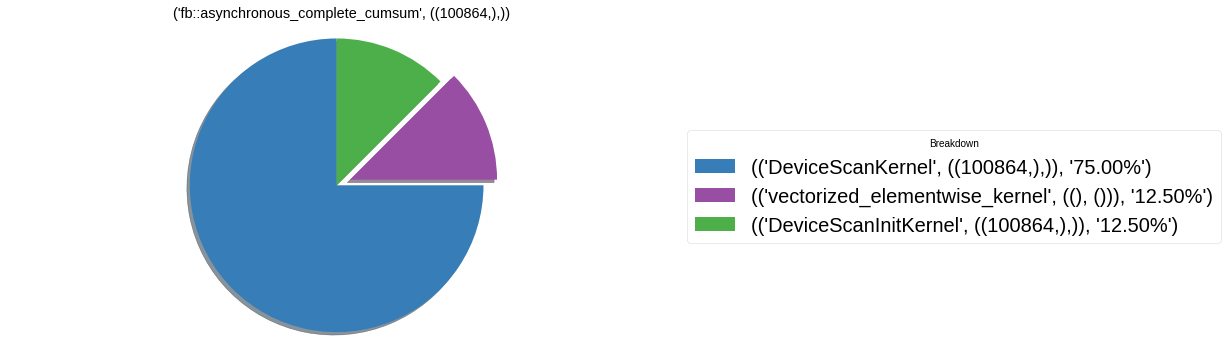

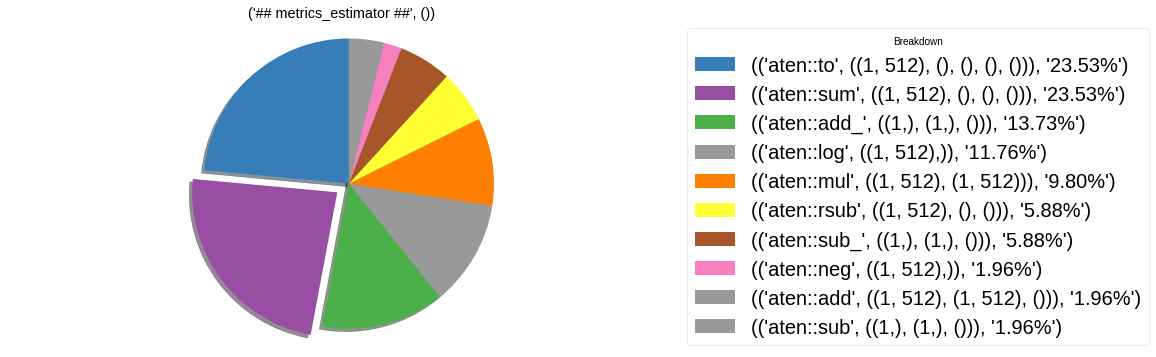

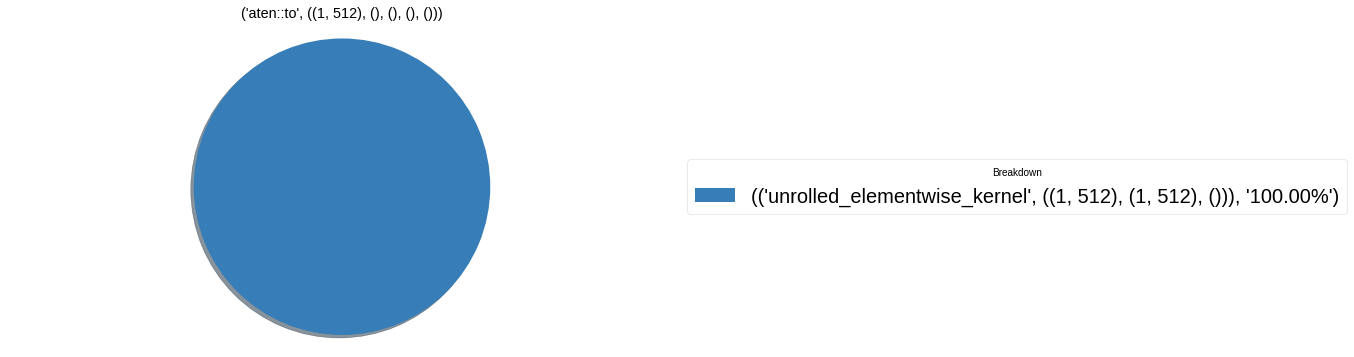

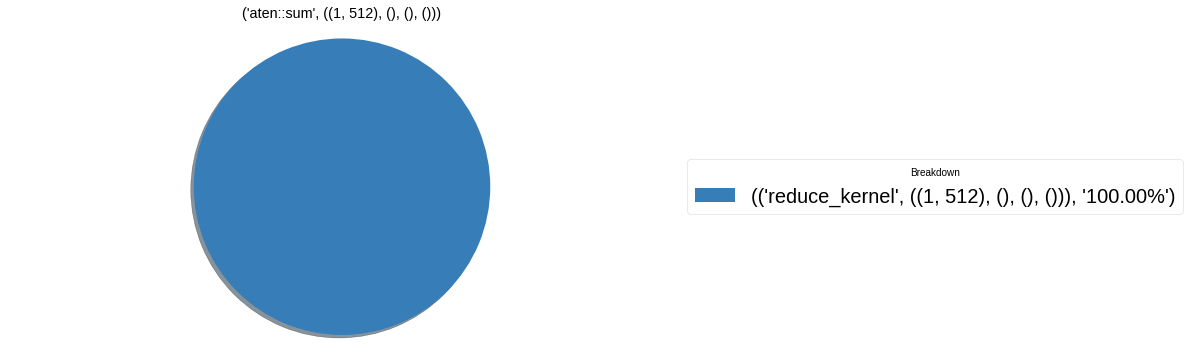

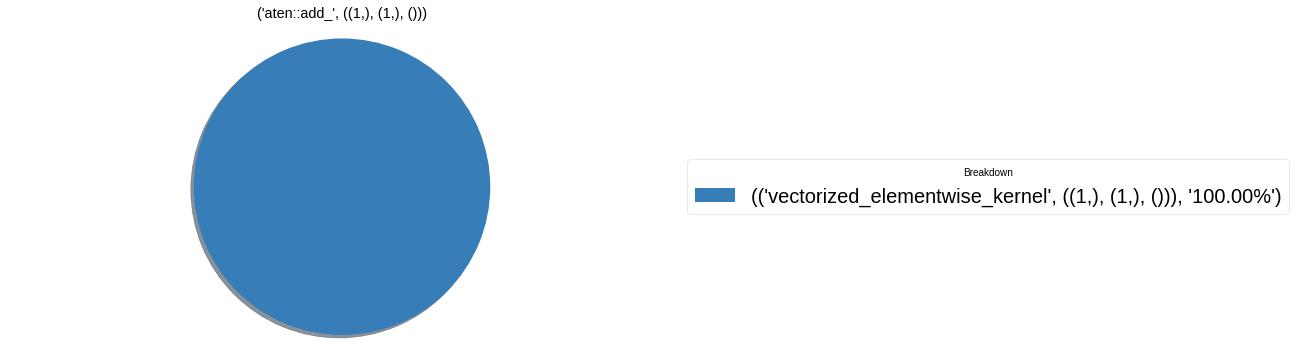

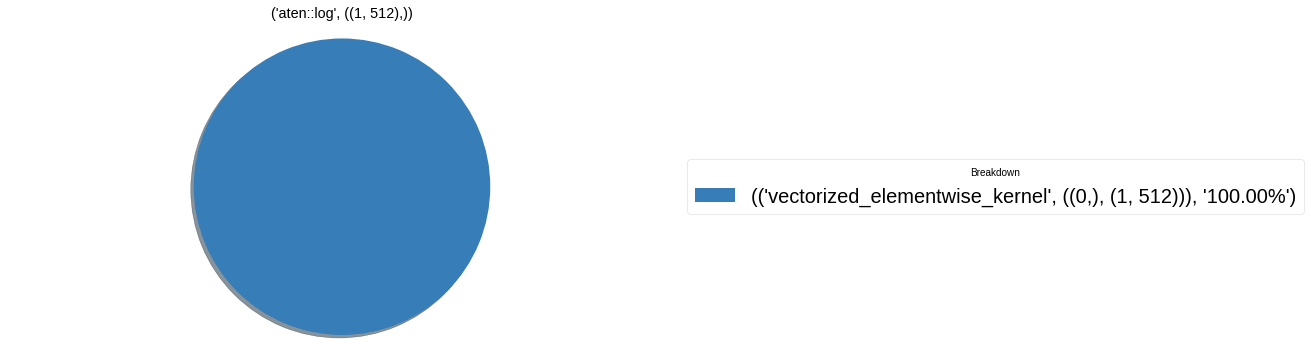

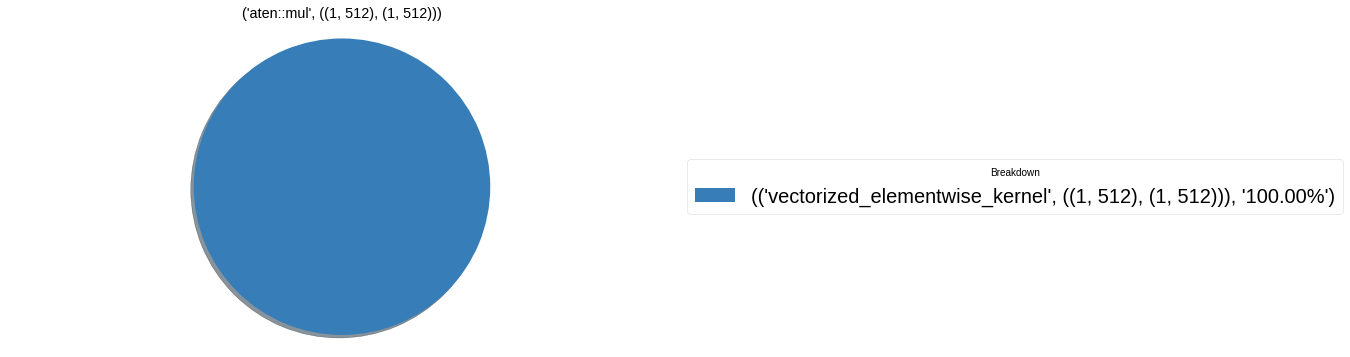

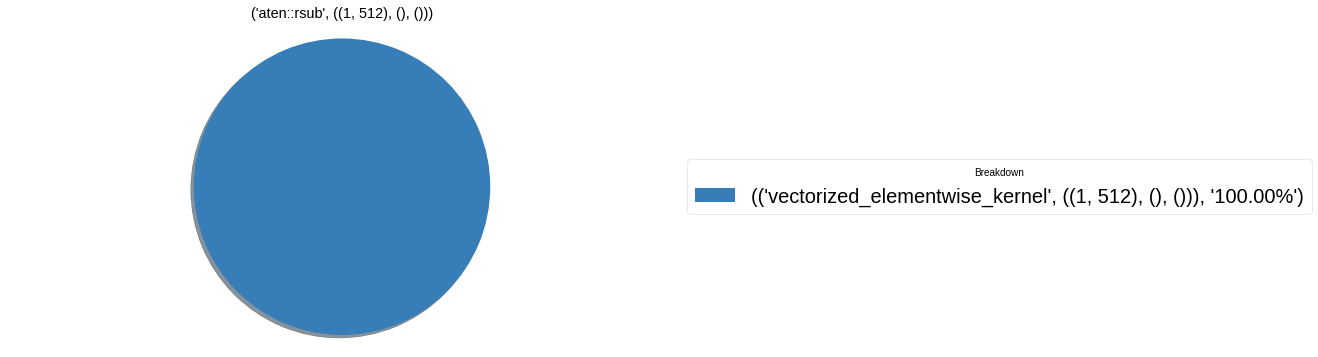

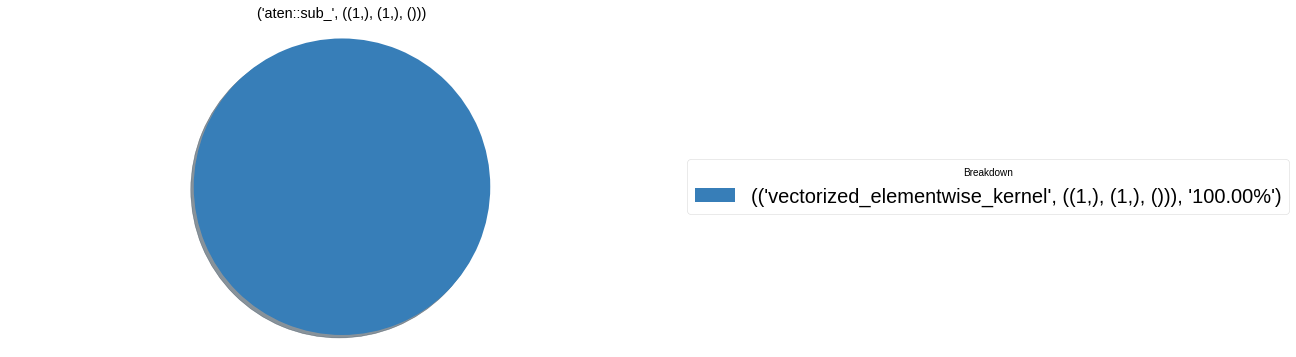

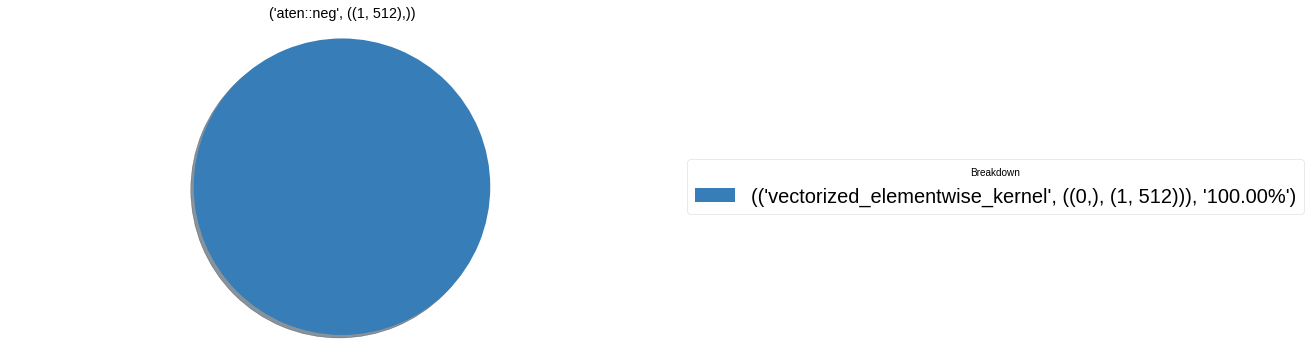

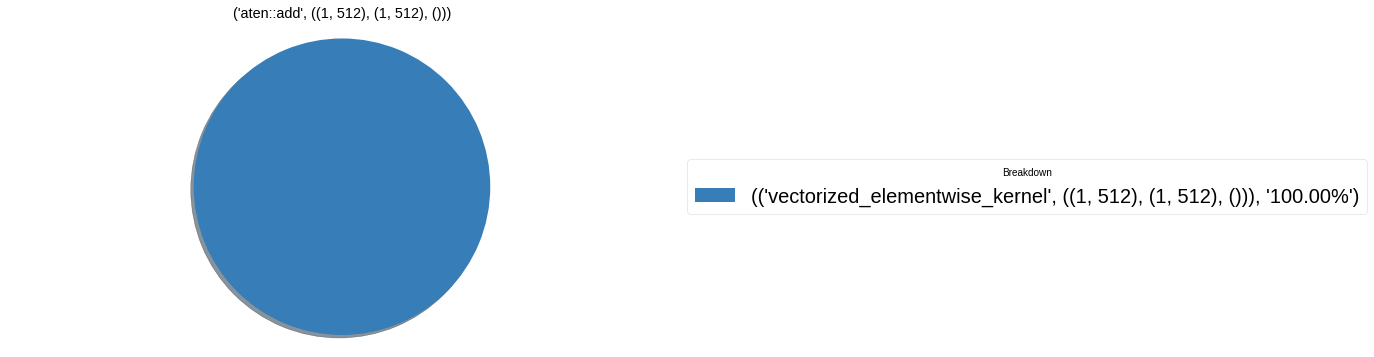

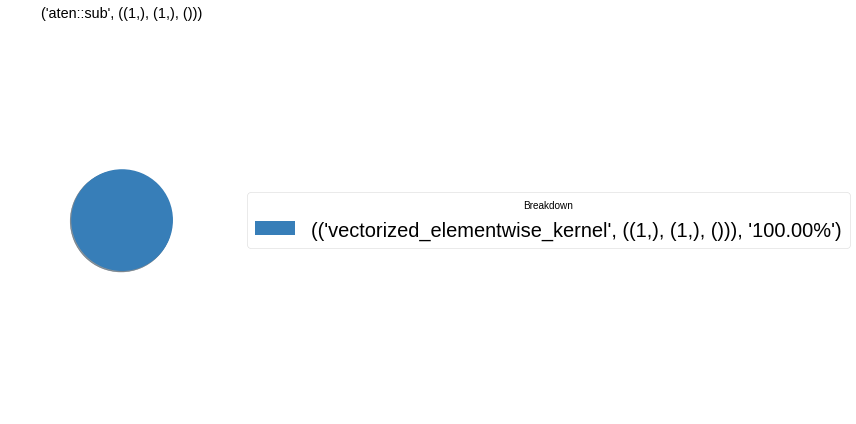

                        Memory Stream


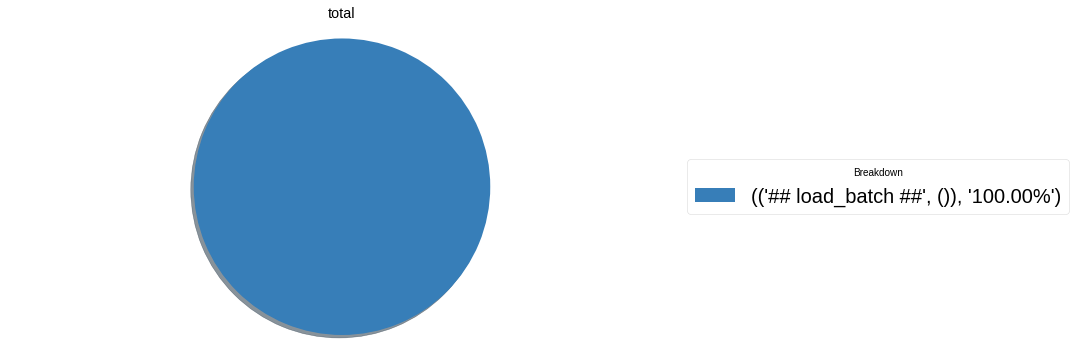

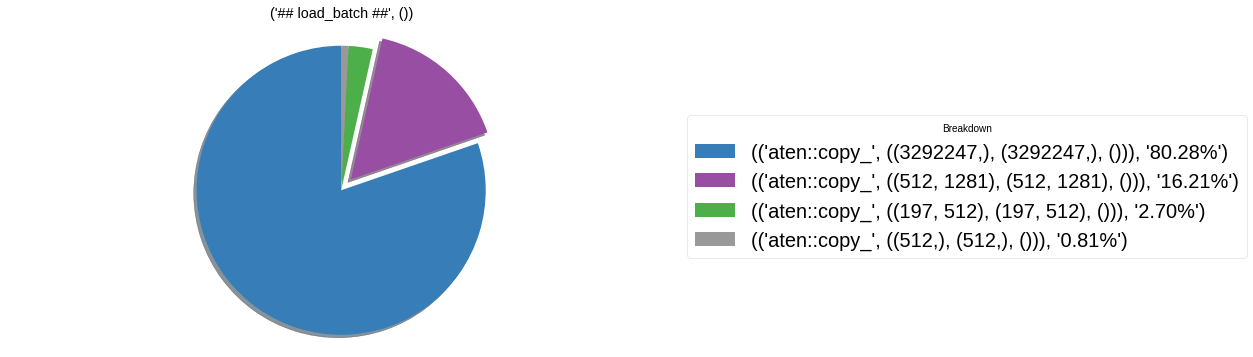

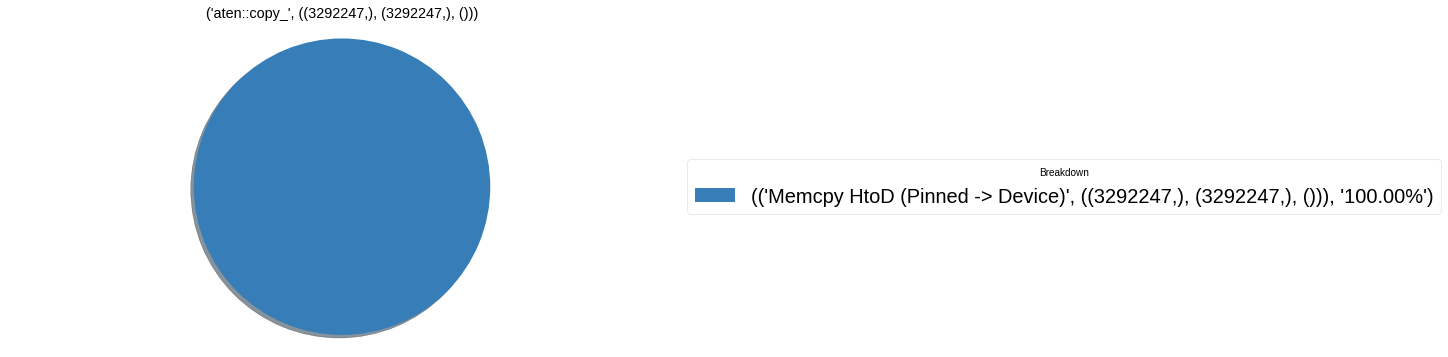

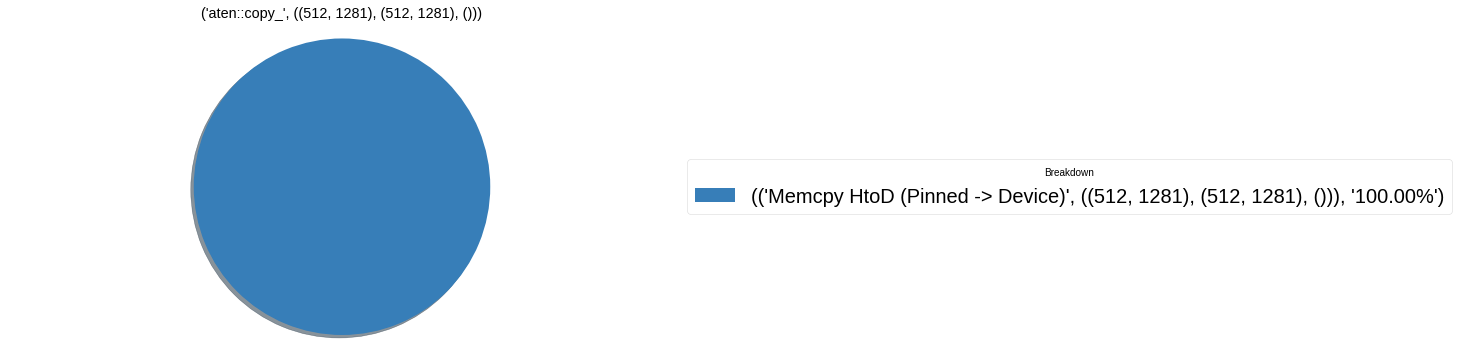

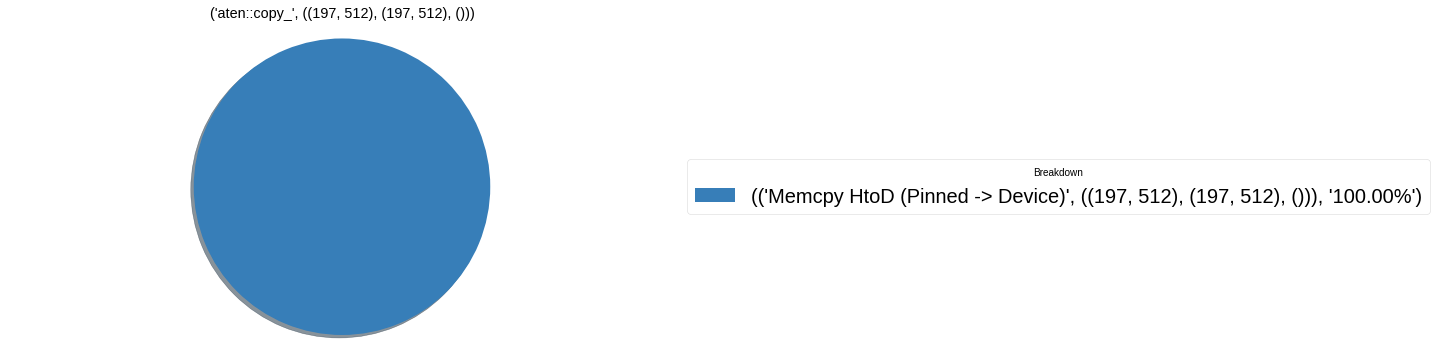

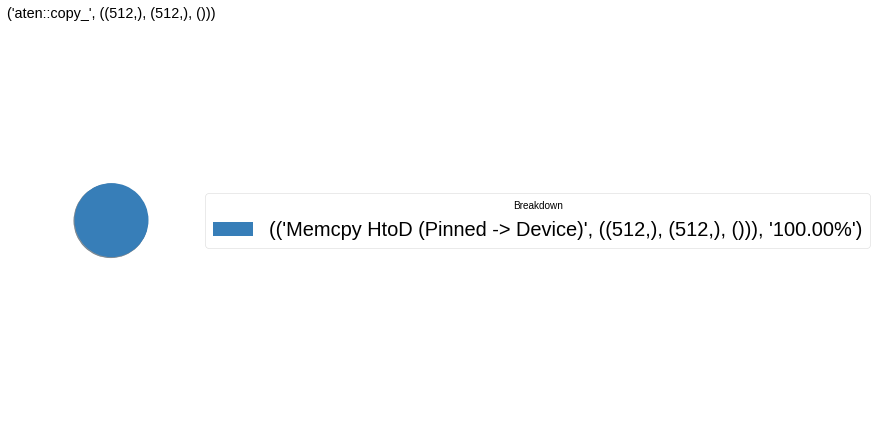

In [65]:
from matplotlib import cm
cs=cm.Set1([1, 3, 2, 25, 4, 5, 6, 7, 8, 11])

def plot_pie_chart(flatten, key="total", truncate_count=100, depth=0):
    d = flatten[key]
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    stats = sorted(d["subs"].items(), key=lambda x: x[1], reverse=True)
    labels = [x[0] for x in stats]
    runtime = [x[1] for x in stats]
    explode = np.zeros(len(runtime))
    if len(explode) > 2:
        explode[1] = 0.1

    fig1, ax1 = plt.subplots(figsize=(12, 6))
    wedges, texts = ax1.pie(runtime, explode=explode, shadow=True, startangle=90, colors=cs)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(key)
    
    ax1.legend(wedges, zip(labels, ["{:.2f}%".format(r / d["runtime"] * 100) for r in runtime]),
          title="Breakdown",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=20)
    
    for label in labels:
        if label in flatten:
            plot_pie_chart(flatten, key=label, truncate_count=truncate_count, depth=depth+1)

    if depth == 0:
        plt.show()

for stream, v in flatten.items():
    print("                        {} Stream".format("Compute" if stream == 7 else "Memory"))
    plot_pie_chart(v, truncate_count=truncate_count)

In [59]:
executor_stats = []
previous_ex_id = None
previous_cr_id = None
for ex_id, v in sorted(cc.items(), key=lambda x: x[0]):
    key_list = sorted(list(v["callees"].keys()))
    for cr_id in key_list:
        if v["callees"][cr_id]["executor"] is not None:
            executor = v["callees"][cr_id]["executor"]
            executor_start = executor.start_time()
            delay = executor_start - v["callees"][cr_id]["launcher"].start_time()
            caller_name = v["caller"].name()
            caller_parent = v["caller"]
            
            if previous_ex_id is not None and previous_cr_id is not None:
                previous_executor = cc[previous_ex_id]["callees"][previous_cr_id]["executor"]
                previous_end = previous_executor.start_time() + previous_executor.duration()
                overhead = executor_start - previous_end
            else:
                overhead = 0
            
            while (caller_parent is not None):
                caller_parent = caller_parent.parent
                if caller_parent is None or caller_parent.name().startswith("## "):
                    break
            executor_stats.append({
                "caller_ex_id": ex_id,
                "caller_name": caller_name,
                "caller_parent_name": caller_parent.name() if caller_parent else None,
                "executor_name": shorten_kernel_name(executor.name()),
                "delay": delay,
                "overhead": overhead,
            })

            # Save previous arguments
            previous_ex_id = ex_id
            previous_cr_id = cr_id
                    
delay_changes = []
overhead_changes = []
for idx in range(len(executor_stats)):
    if idx == 0:
        continue
    executor = executor_stats[idx]["executor_name"]
    caller_name = executor_stats[idx]["caller_name"]
    caller_parent = executor_stats[idx]["caller_parent_name"]
    previous_executor = executor_stats[idx-1]["executor_name"]
    previous_caller_name = executor_stats[idx-1]["caller_name"]
    previous_caller_parent = executor_stats[idx-1]["caller_parent_name"]
    delay_changes.append((executor, caller_name, caller_parent, previous_executor, previous_caller_name, previous_caller_parent, (executor_stats[idx]["delay"] - executor_stats[idx-1]["delay"])))
    overhead_changes.append((executor, caller_name, caller_parent, previous_executor, previous_caller_name, previous_caller_parent, (executor_stats[idx]["overhead"])))
for x in sorted(overhead_changes, key=lambda x: x[6], reverse=True)[:20]:
    print("Current: ", x[0], x[1], x[2])
    print("\tPrevious: ", x[3], x[4], x[5])
    print("\tOverhead: ", x[6])
# print(sorted(delay_changes, key=lambda x: x[6], reverse=True)[:5])

Current:  void multi_tensor_apply_kernel ## optimizer ## None
	Previous:  Memcpy HtoD (Pinned -> Device) aten::copy_ ## load_batch ##
	Overhead:  1115
Current:  void multi_tensor_apply_kernel ## optimizer ## None
	Previous:  Memcpy HtoD (Pinned -> Device) aten::copy_ ## load_batch ##
	Overhead:  1077
Current:  vectorized_elementwise_kernel aten::exp ## forward:over_arch ##
	Previous:  vectorized_elementwise_kernel aten::sub ## forward:over_arch ##
	Overhead:  667
Current:  unrolled_elementwise_kernel aten::div ## backward ##
	Previous:  vectorized_elementwise_kernel aten::fill_ ## backward ##
	Overhead:  196
Current:  unrolled_elementwise_kernel aten::div ## backward ##
	Previous:  vectorized_elementwise_kernel aten::fill_ ## backward ##
	Overhead:  181
Current:  reduce_kernel aten::sum ## backward ##
	Previous:  reduce_kernel aten::mean ## forward:over_arch ##
	Overhead:  162
Current:  Memset (Device) aten::mm ## backward ##
	Previous:  vectorized_elementwise_kernel aten::threshold_ba

### Multistream analysis

In [46]:
all_kernels = []
for _, c in cc.items():
    for _, v in c["callees"].items():
        if v["executor"] is not None:
            all_kernels.append(v["executor"])
all_kernels = sorted(all_kernels, key=lambda x: x.start_time())

idle_time = 0
last_end = all_kernels[0].start_time() + all_kernels[0].duration()
overlapped = 0
for k in all_kernels:
    if k.start_time() > last_end:
        idle_time += k.start_time() - last_end
        last_end = k.start_time() + k.duration()
    else:
        last_end = max(last_end, k.start_time() + k.duration())
        overlapped += min(last_end, k.start_time() + k.duration()) - k.start_time()

print("device_runtime", device_runtime)
print("idle_time:", idle_time)
print("overlapped_time", overlapped)

device_runtime 23806
idle_time: 11407
overlapped_time 3070
